<a href="https://colab.research.google.com/github/Charlieglider/ExoskeletonMLModel/blob/main/exomodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

LSTM ML Model to classify lifting, holding and lowering with exoskeleton sensor suit data. Inspired by code from https://towardsdatascience.com/time-series-classification-for-human-activity-recognition-with-lstms-using-tensorflow-2-and-keras-*b816431afdff*

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)








In [5]:
#### Importing data
print('Loading data ...')
test = pd.read_csv('/content/test copy.csv')
train = pd.read_csv('/content/train copy.csv')
train.head()


Loading data ...


,Task,Millis,FSR 3,system_cal,theta_comp,Shoulder X,Shoulder Y,Elbow X,Elbow
0,lifting,16119.0,14.0,89.67,29.77,1.39,-35.06,-13.48,45.0
1,lifting,16130.0,12.0,89.66,29.76,1.39,-35.06,-13.48,45.0
2,lifting,16140.0,16.0,89.65,29.65,1.39,-35.06,-13.48,45.0
3,lifting,16150.0,15.0,89.66,29.59,1.39,-35.06,-13.48,45.0
4,lifting,16160.0,12.0,89.69,29.48,1.39,-35.06,-13.48,45.0


In [6]:
train.shape

(662, 9)

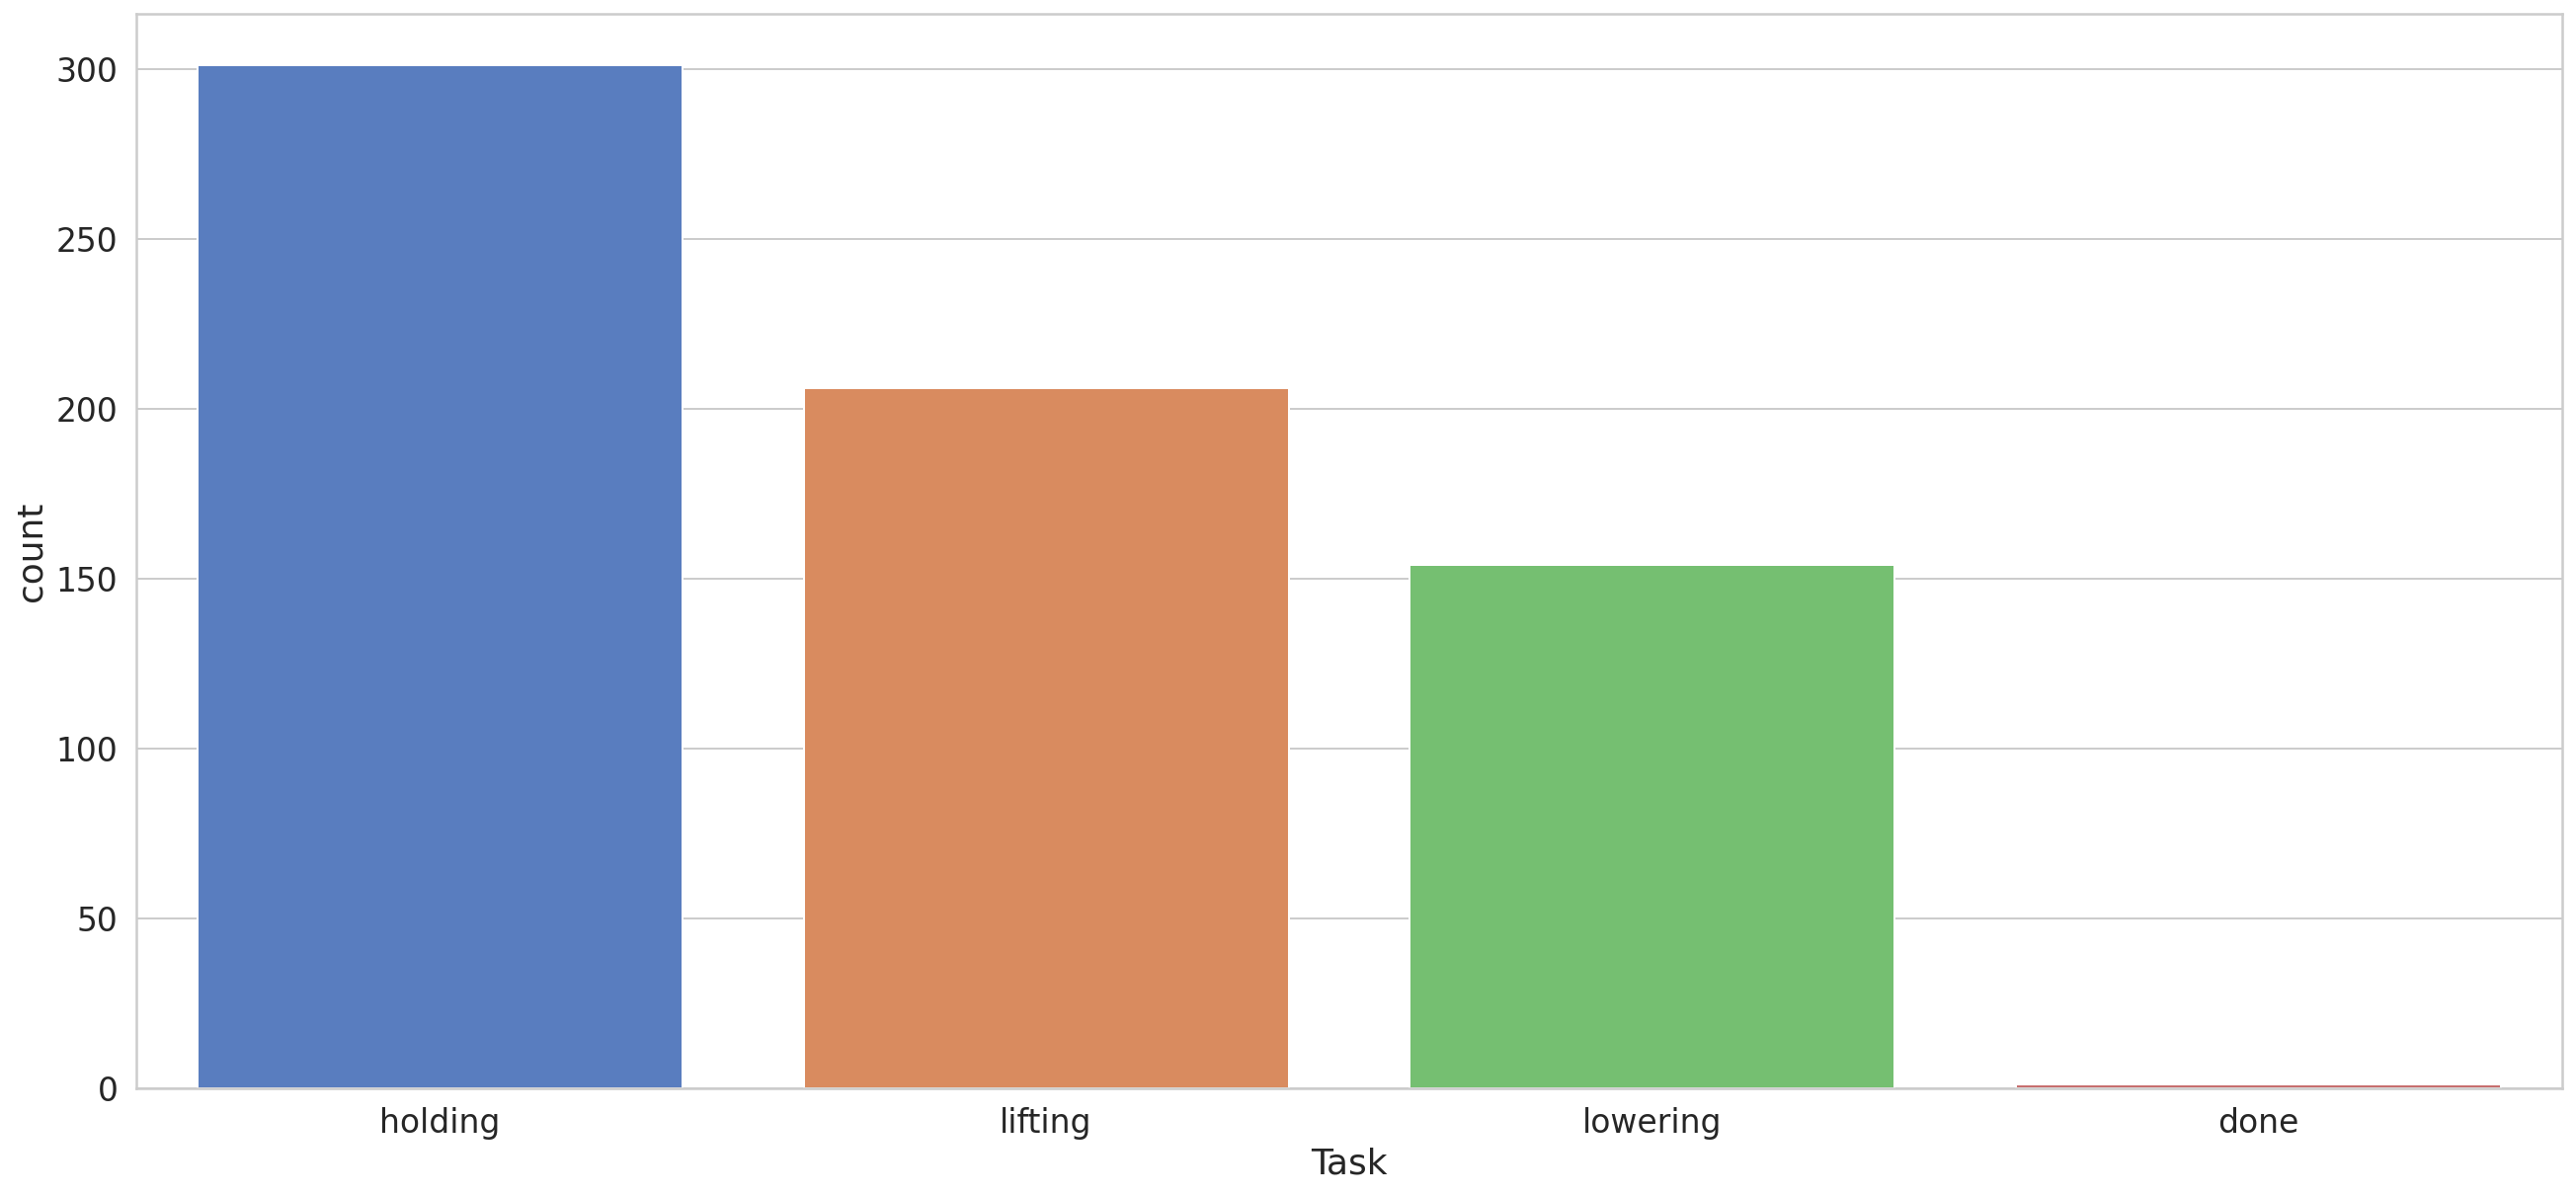

In [7]:
sns.countplot(x = 'Task',
              data = train,
              order = train.Task.value_counts().index);

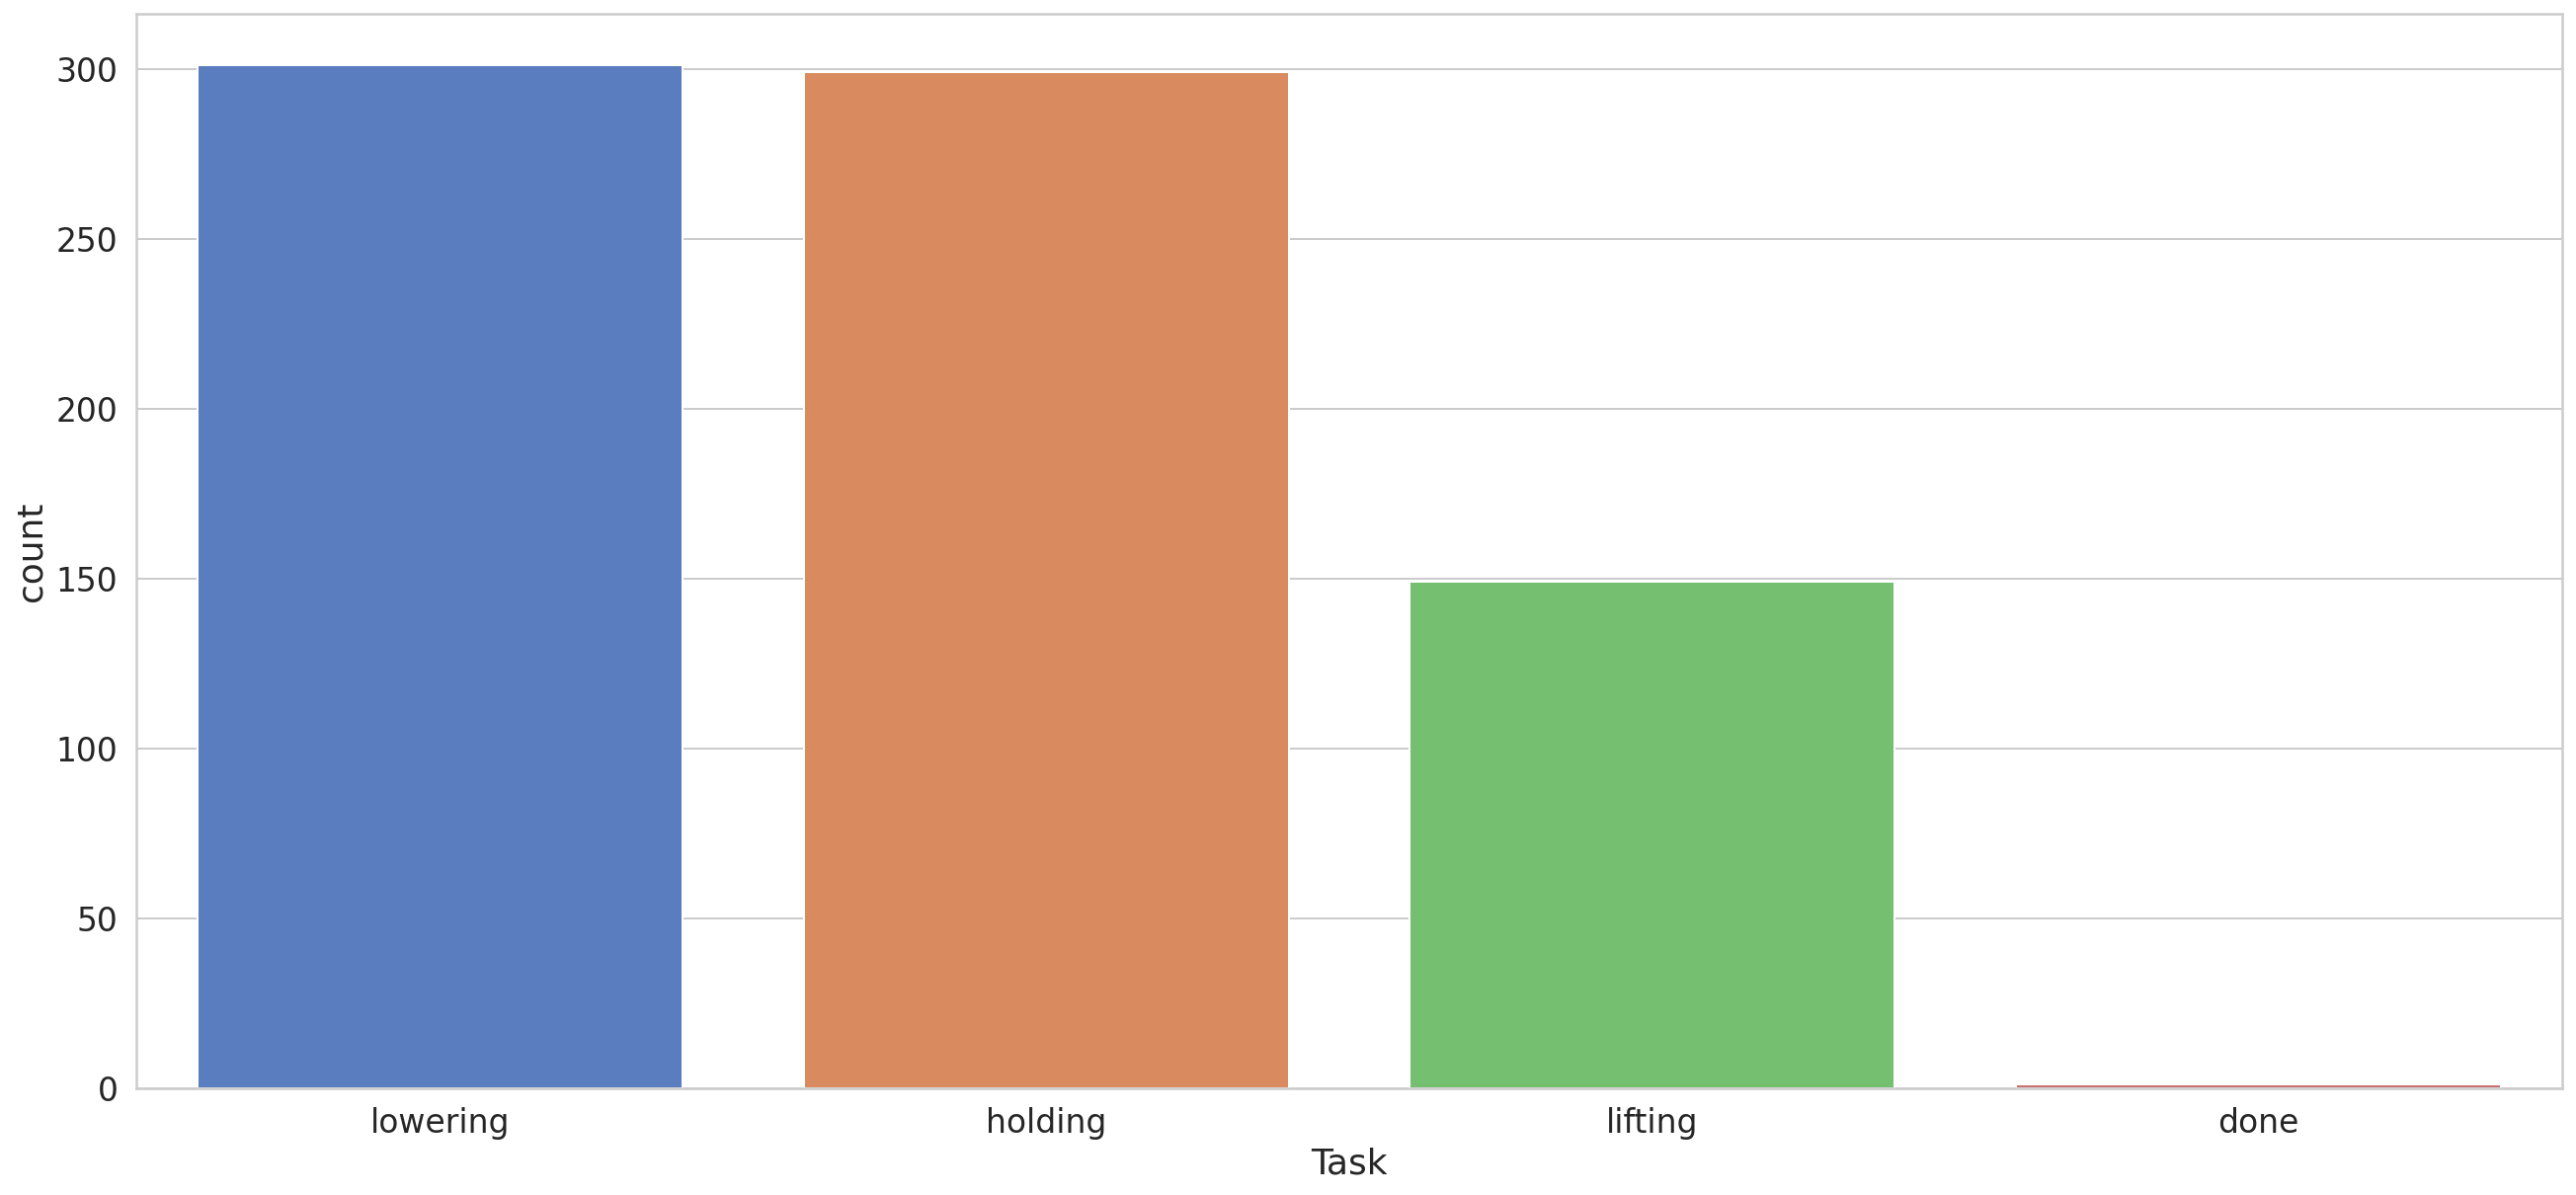

In [8]:
sns.countplot(x = 'Task',
              data = test,
              order = test.Task.value_counts().index);

In [9]:
def plot_activity(activity, dat):
    data = dat[dat['Task'] == activity][['FSR 3', 'system_cal ', 'theta_comp ', 'Shoulder X', 'Shoulder Y', 'Elbow X', 'Elbow']][:200]
    #data = train[train['Task'] == activity][['FSR 3', 'system_cal ', 'theta_comp']][:200]

    axis = data.plot(subplots=True, figsize=(16, 12), 
                     title=activity)
    for ax in axis:
        ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))

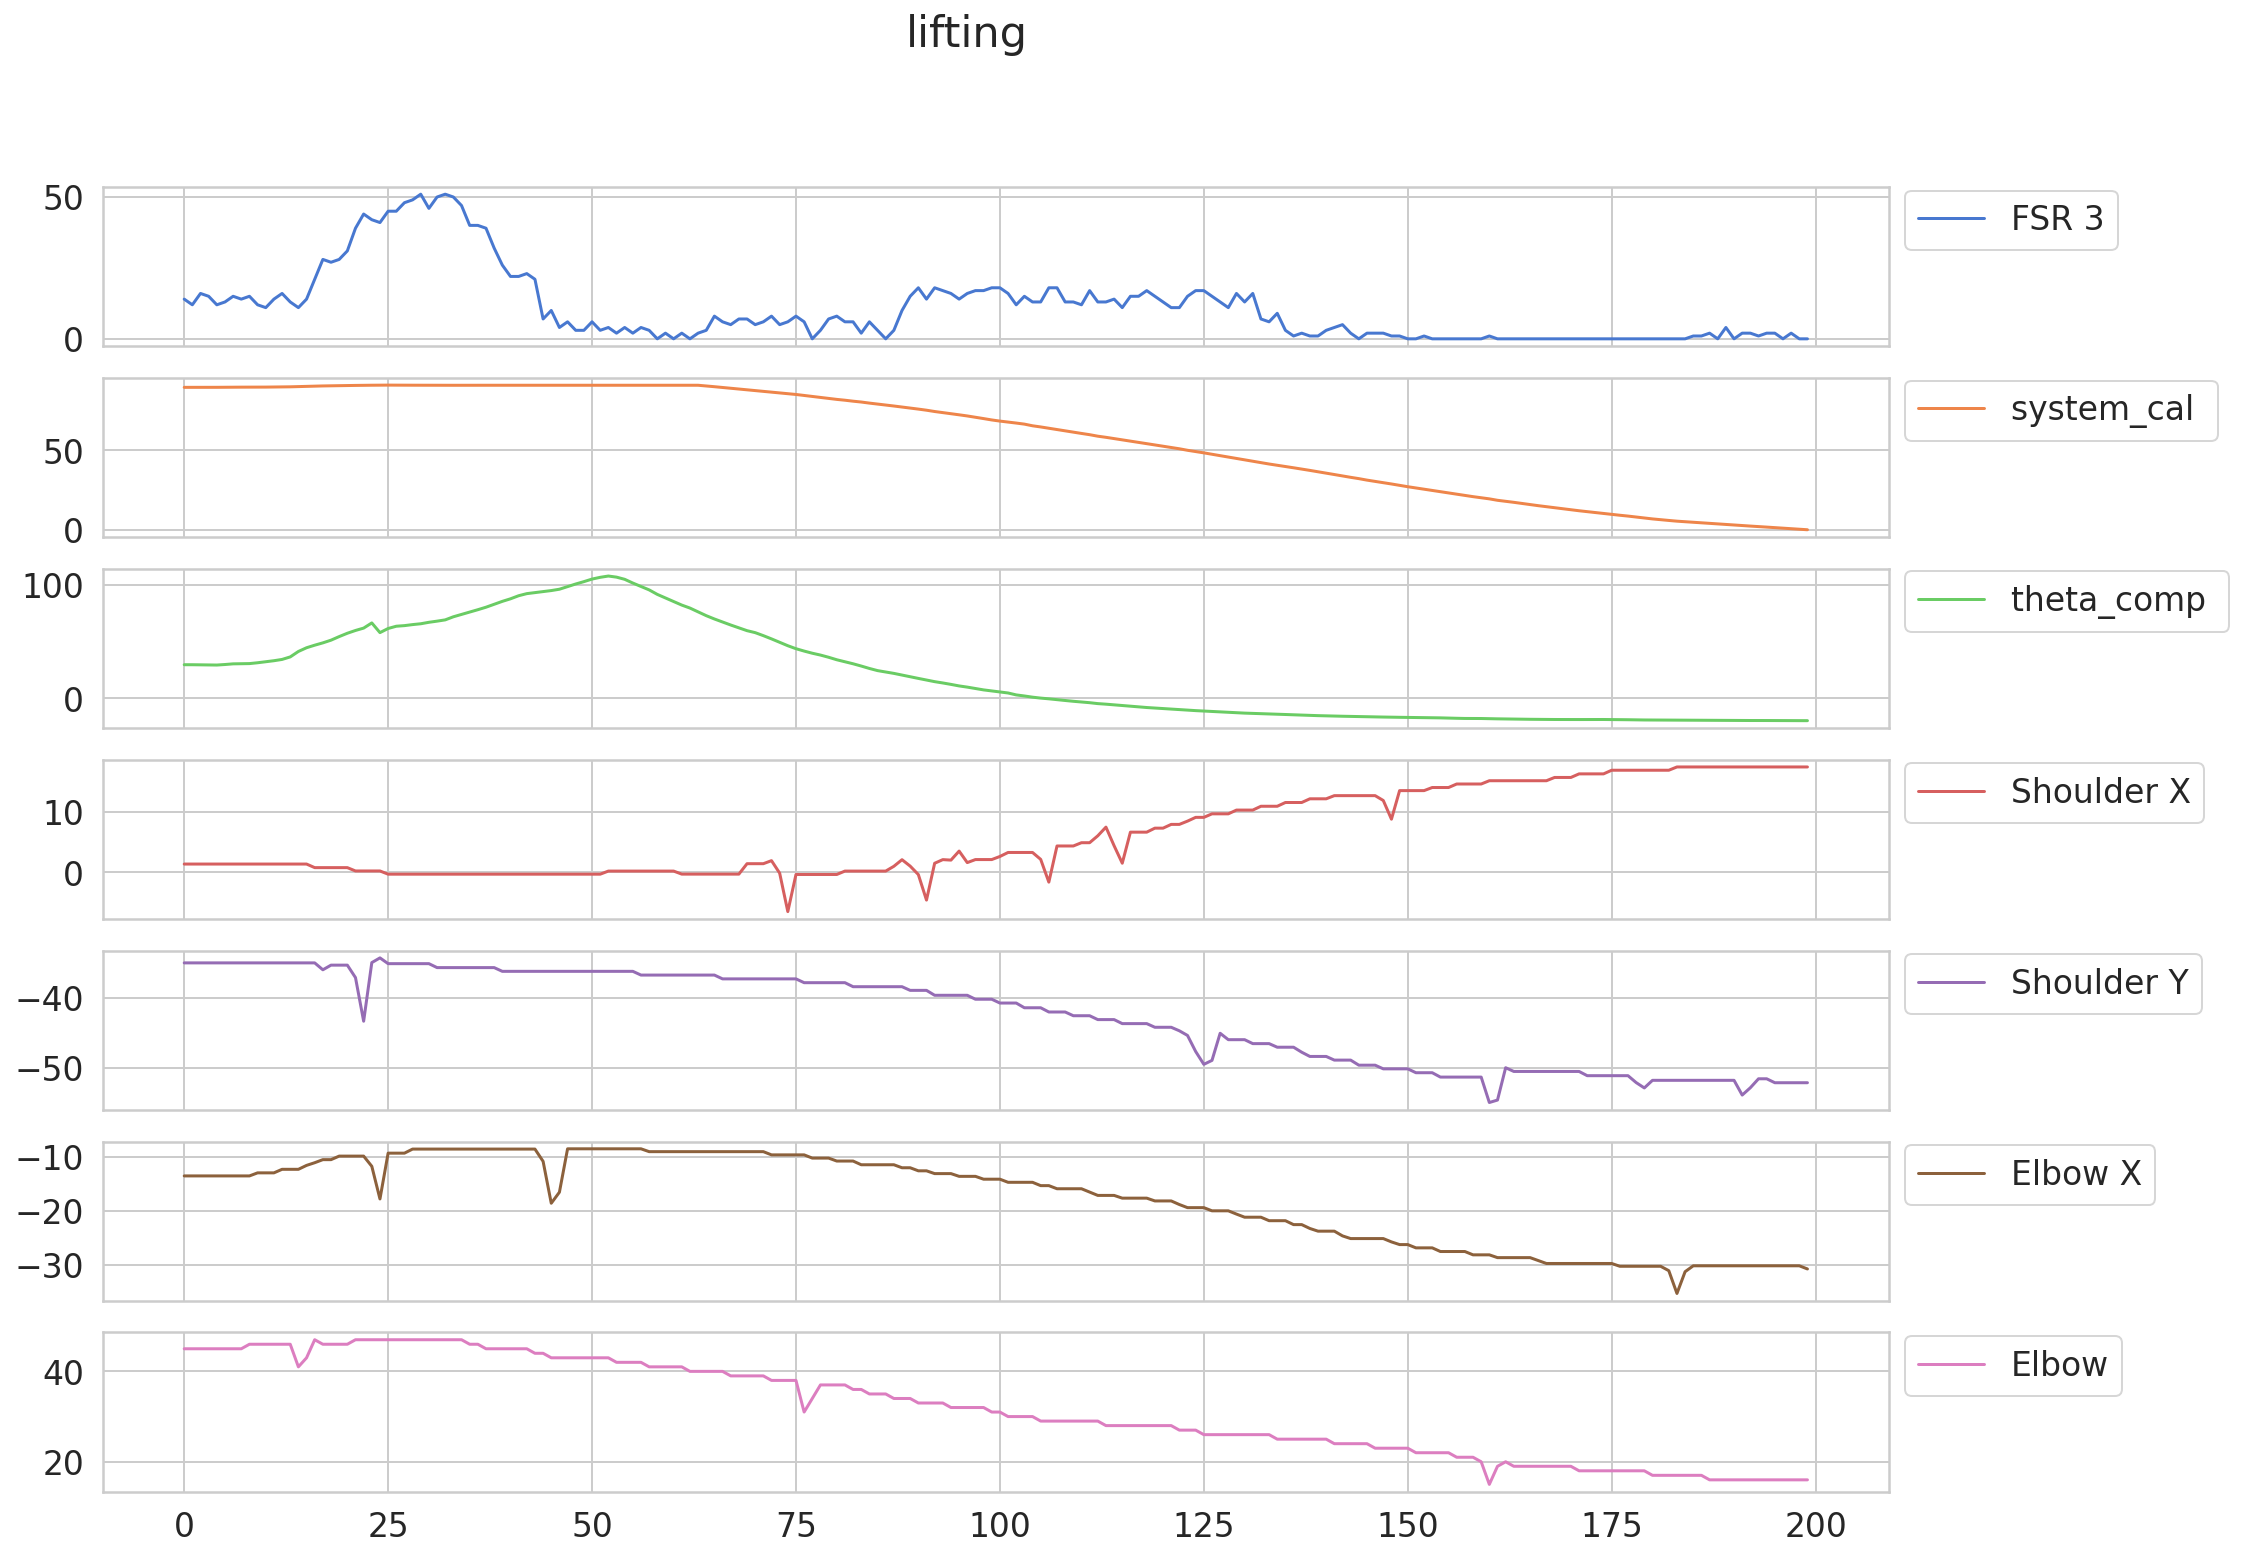

In [10]:
plot_activity("lifting", train)

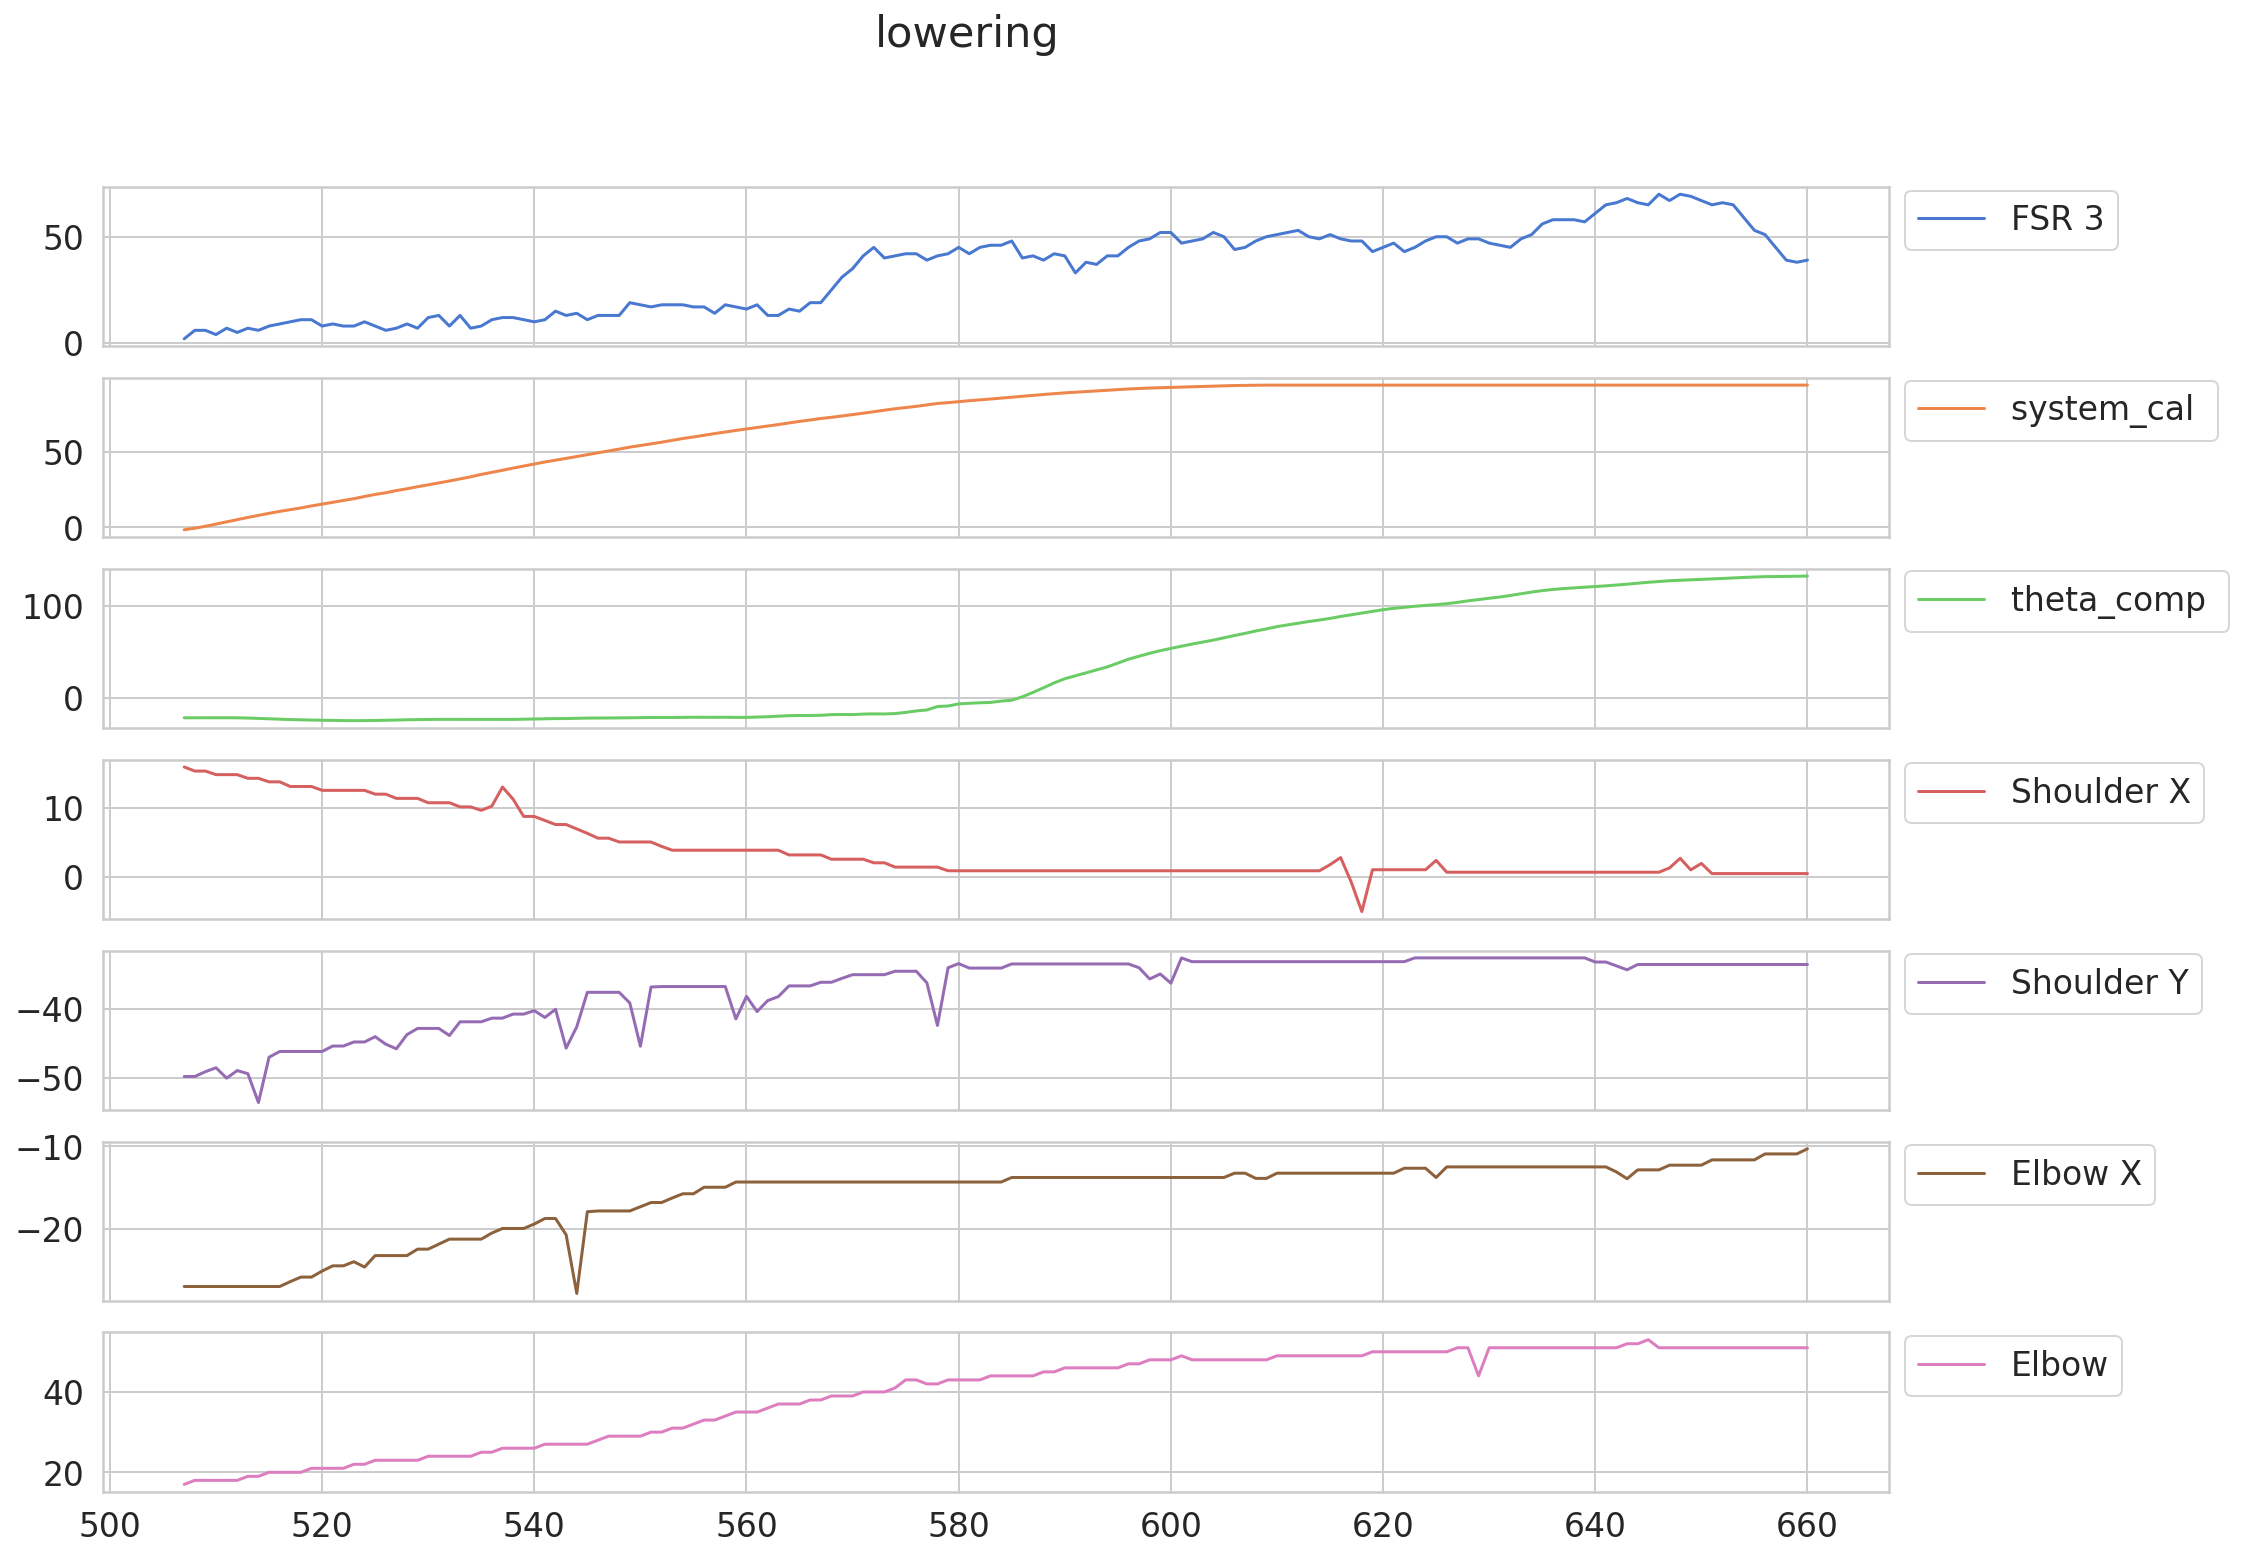

In [11]:
plot_activity("lowering", train)



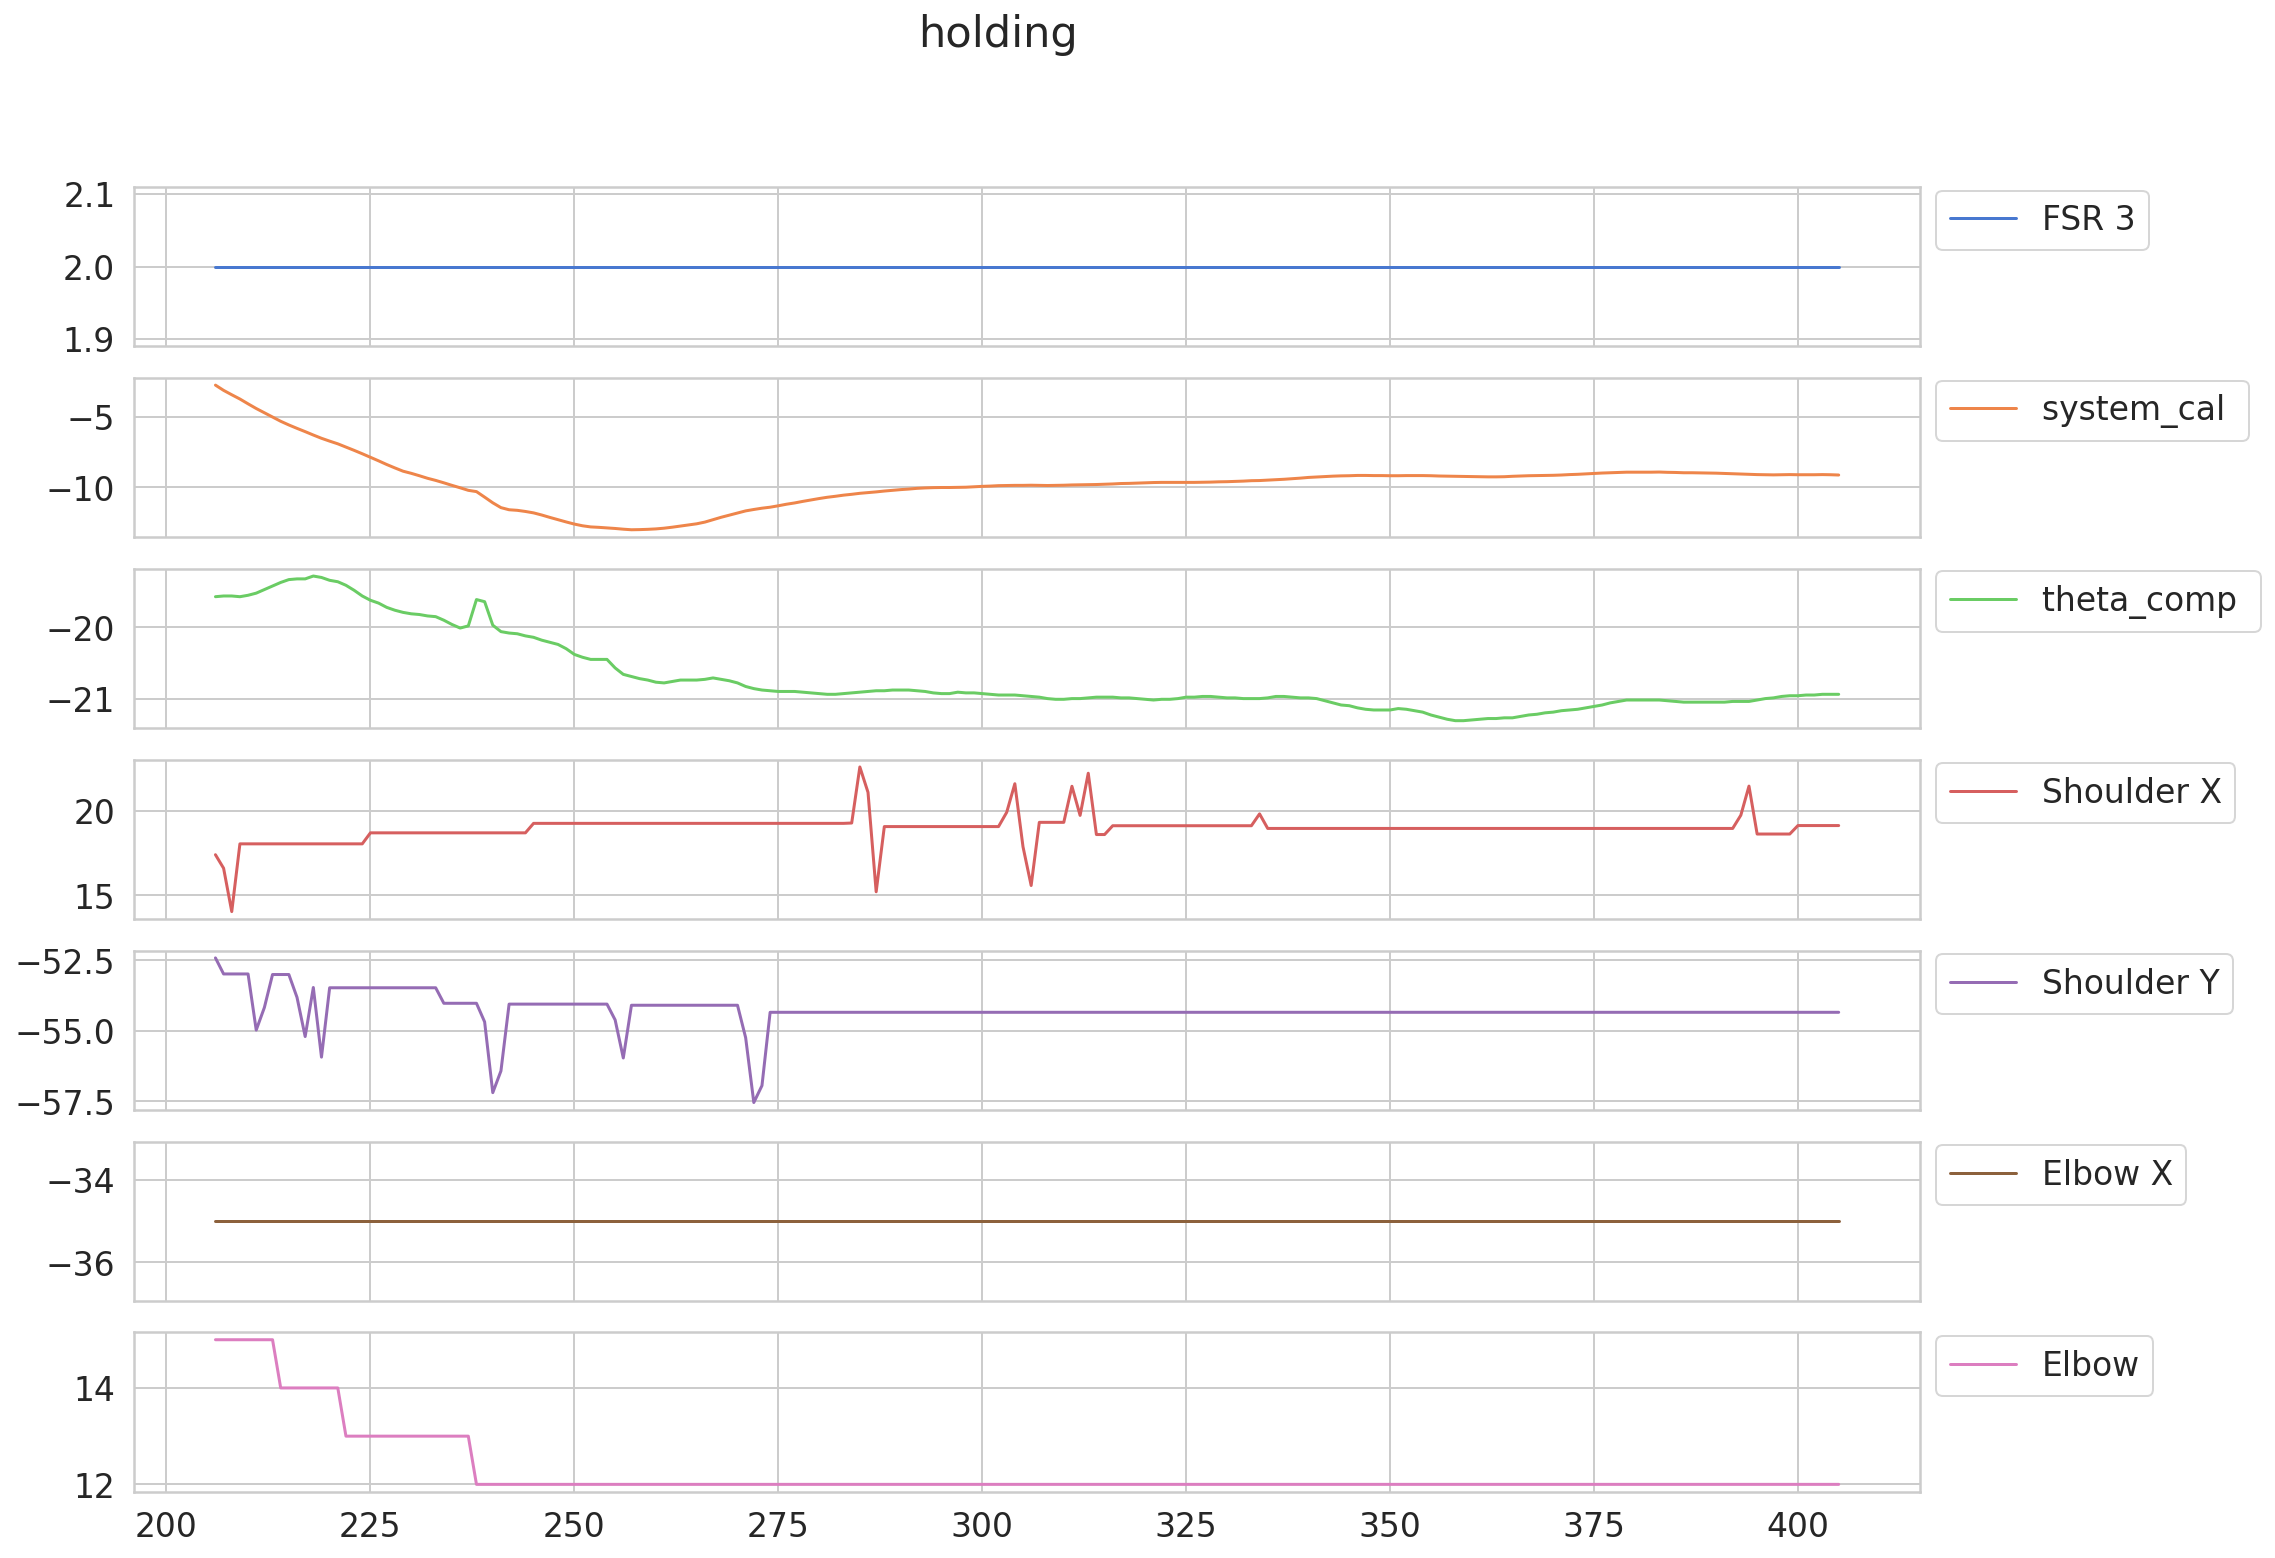

In [12]:
plot_activity("holding", train)



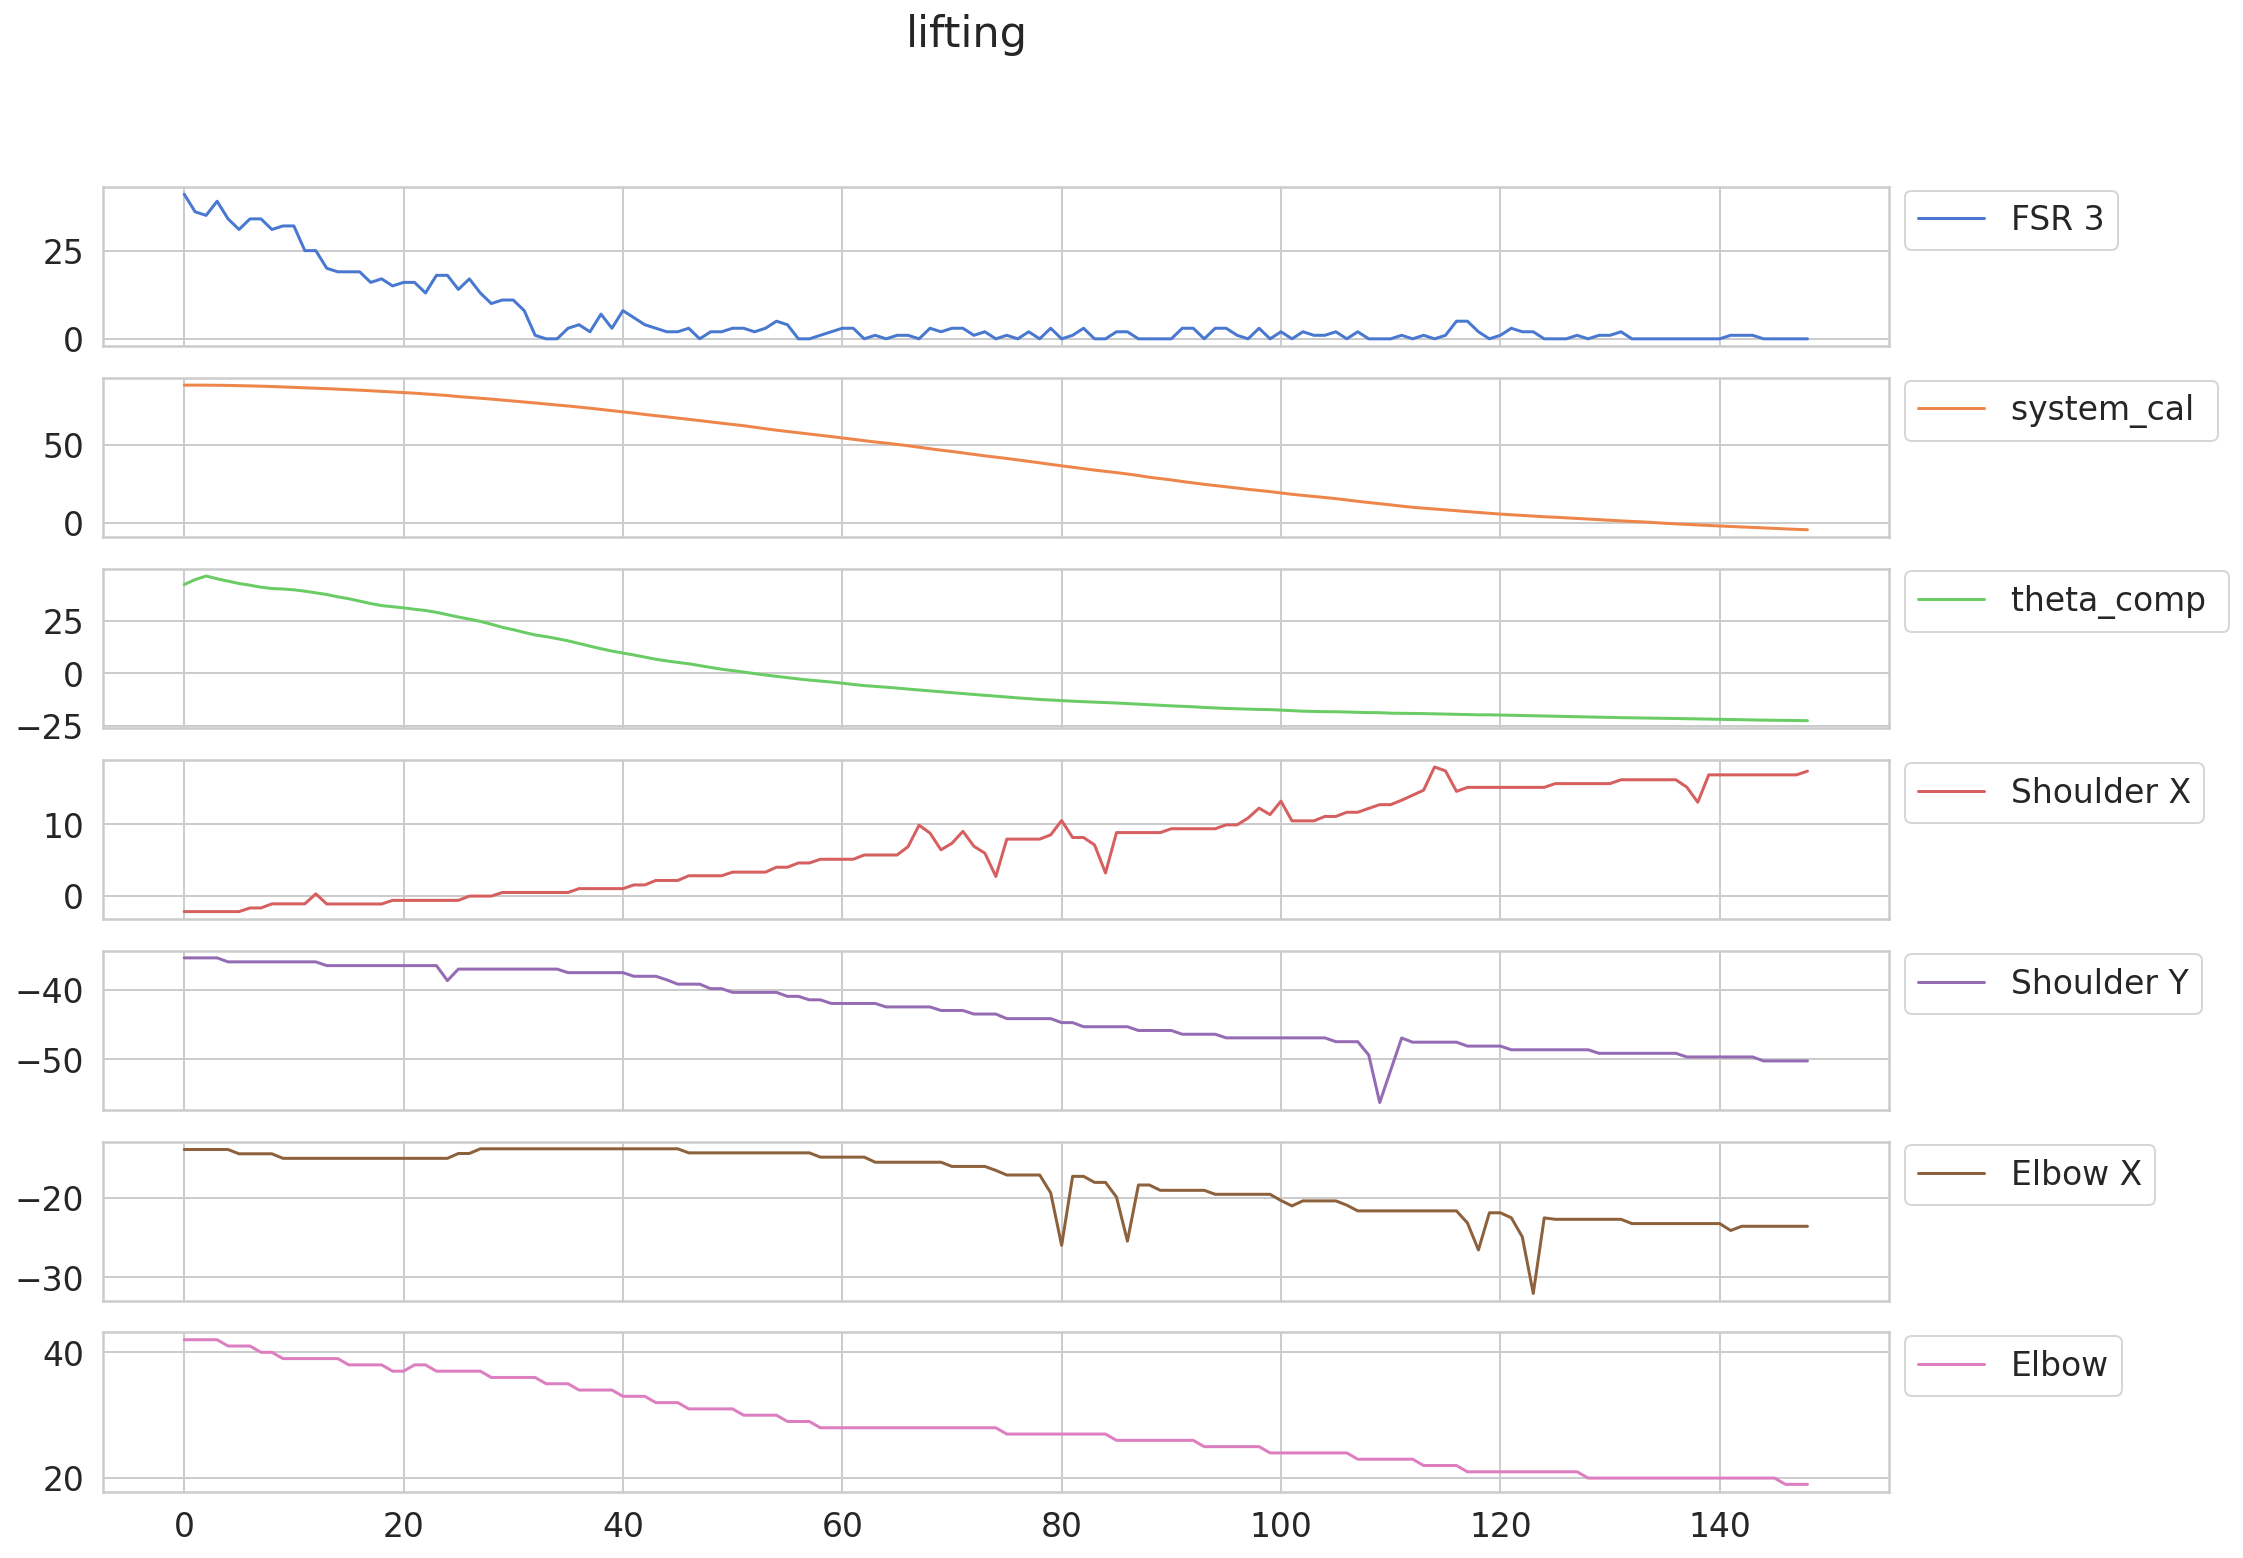

In [13]:
plot_activity("lifting", test)

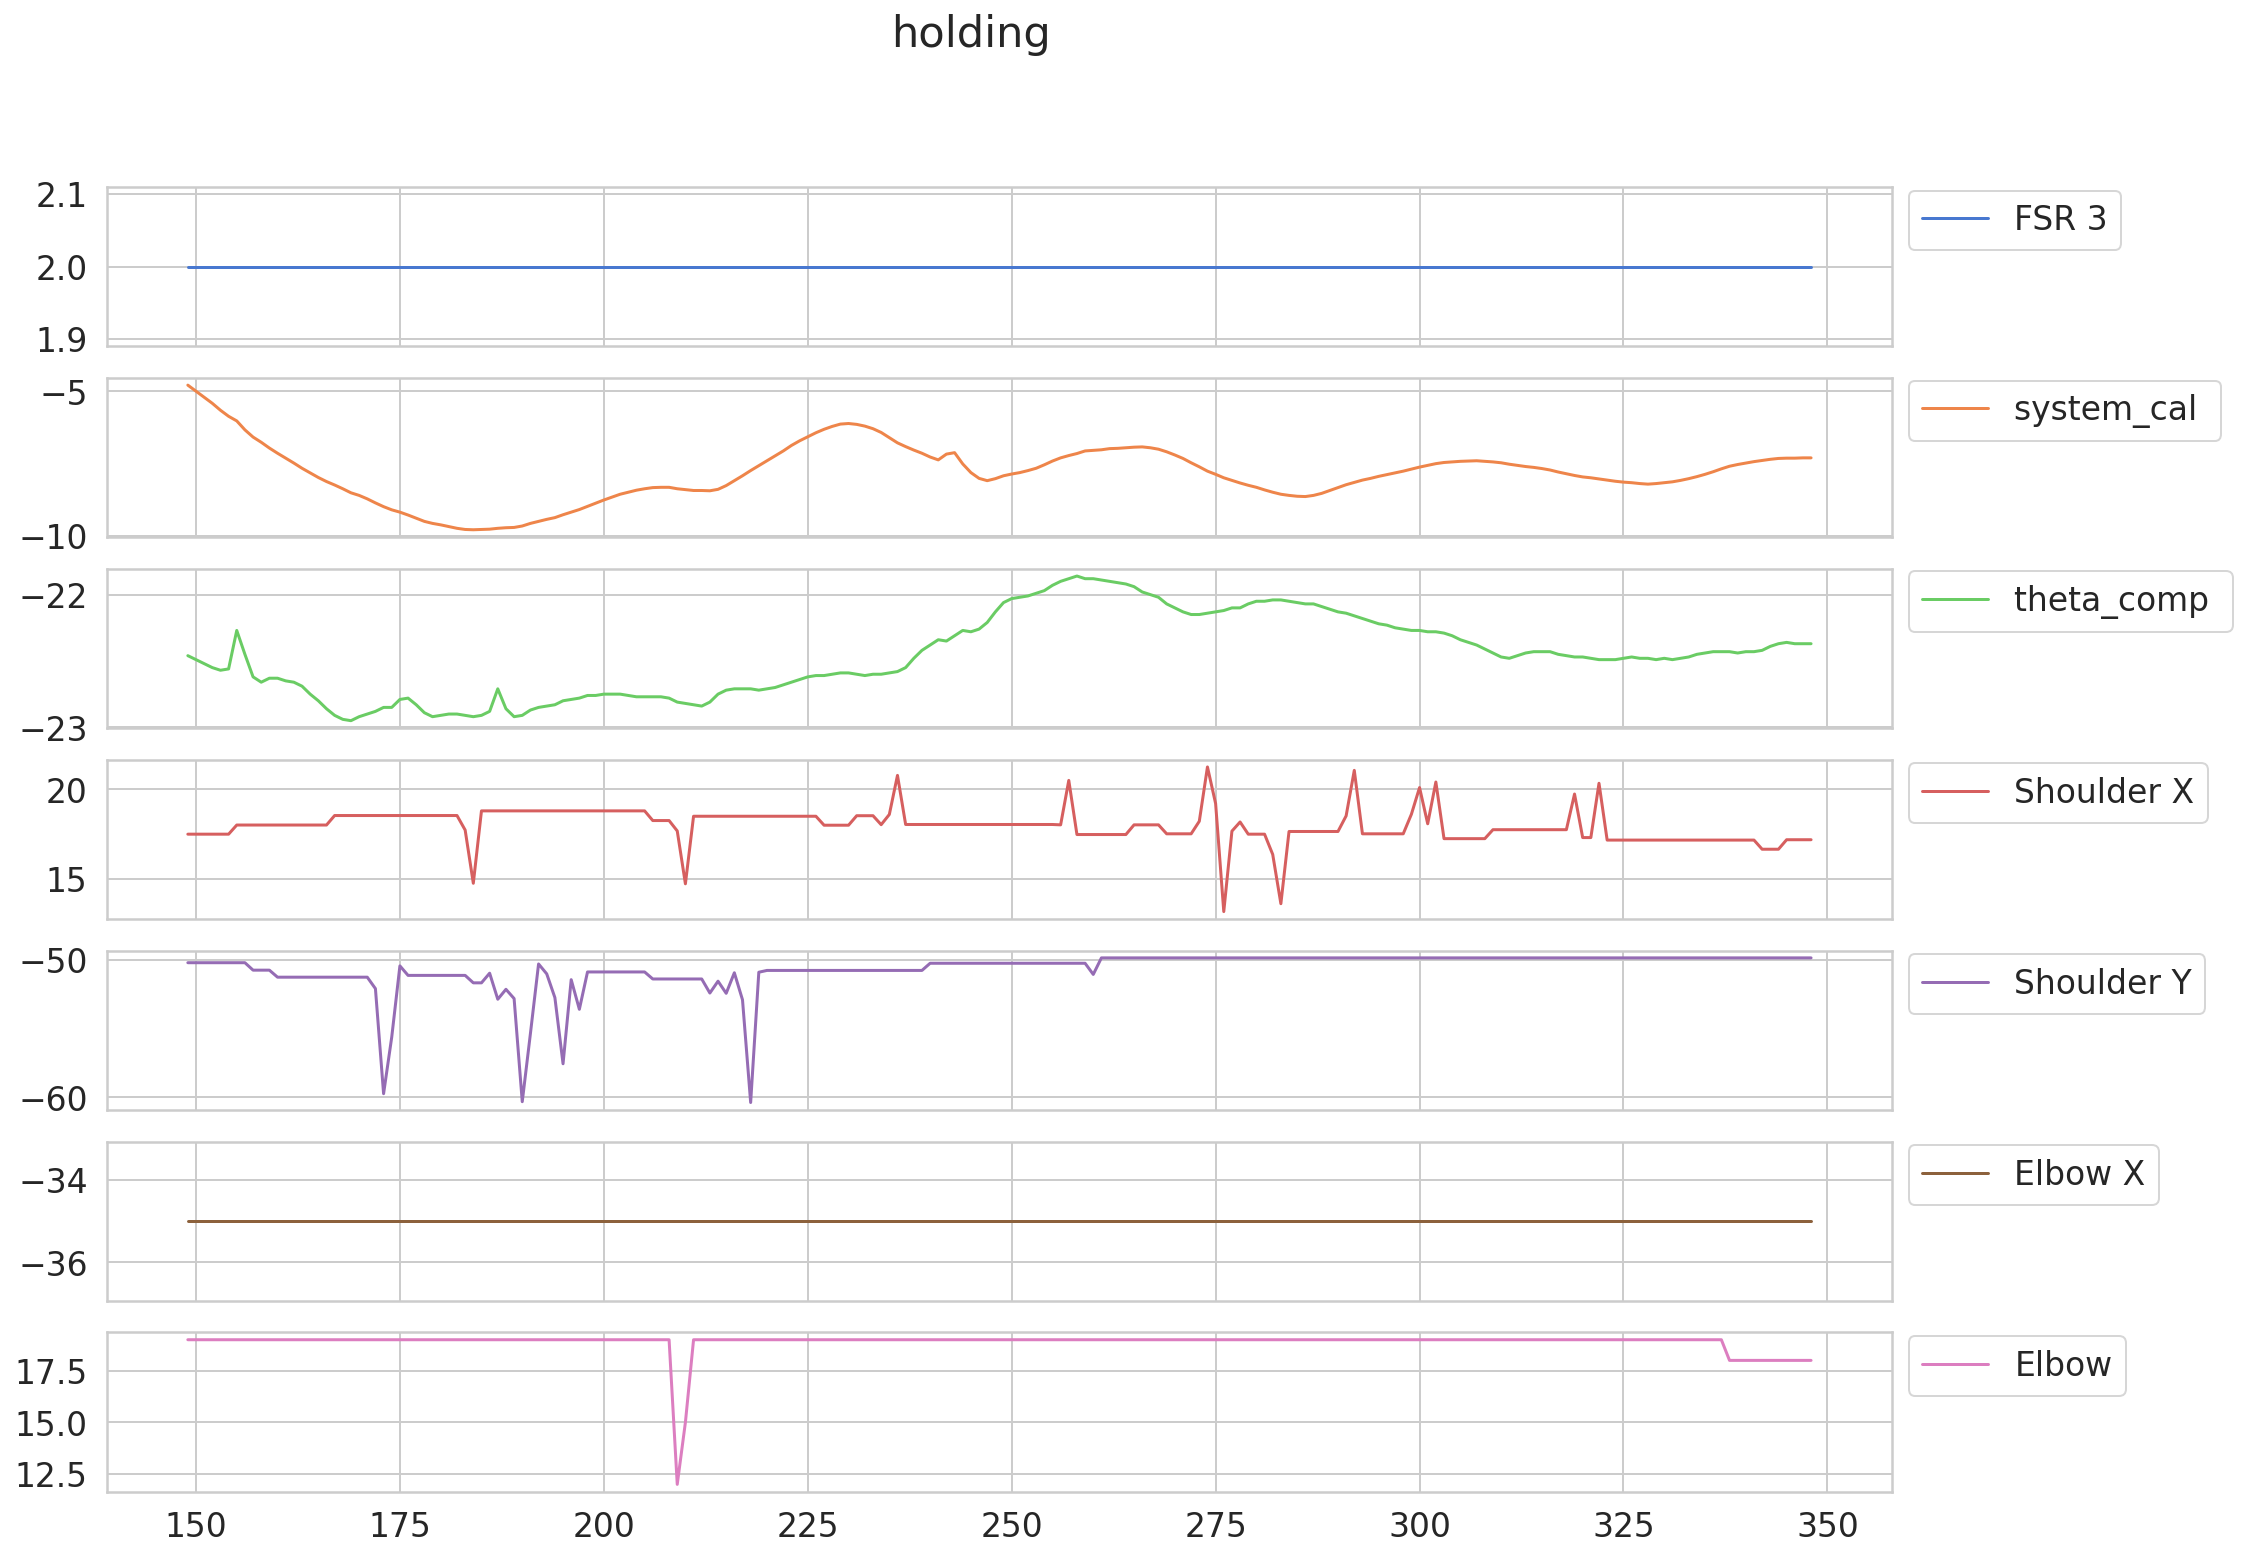

In [14]:
plot_activity("holding", test)

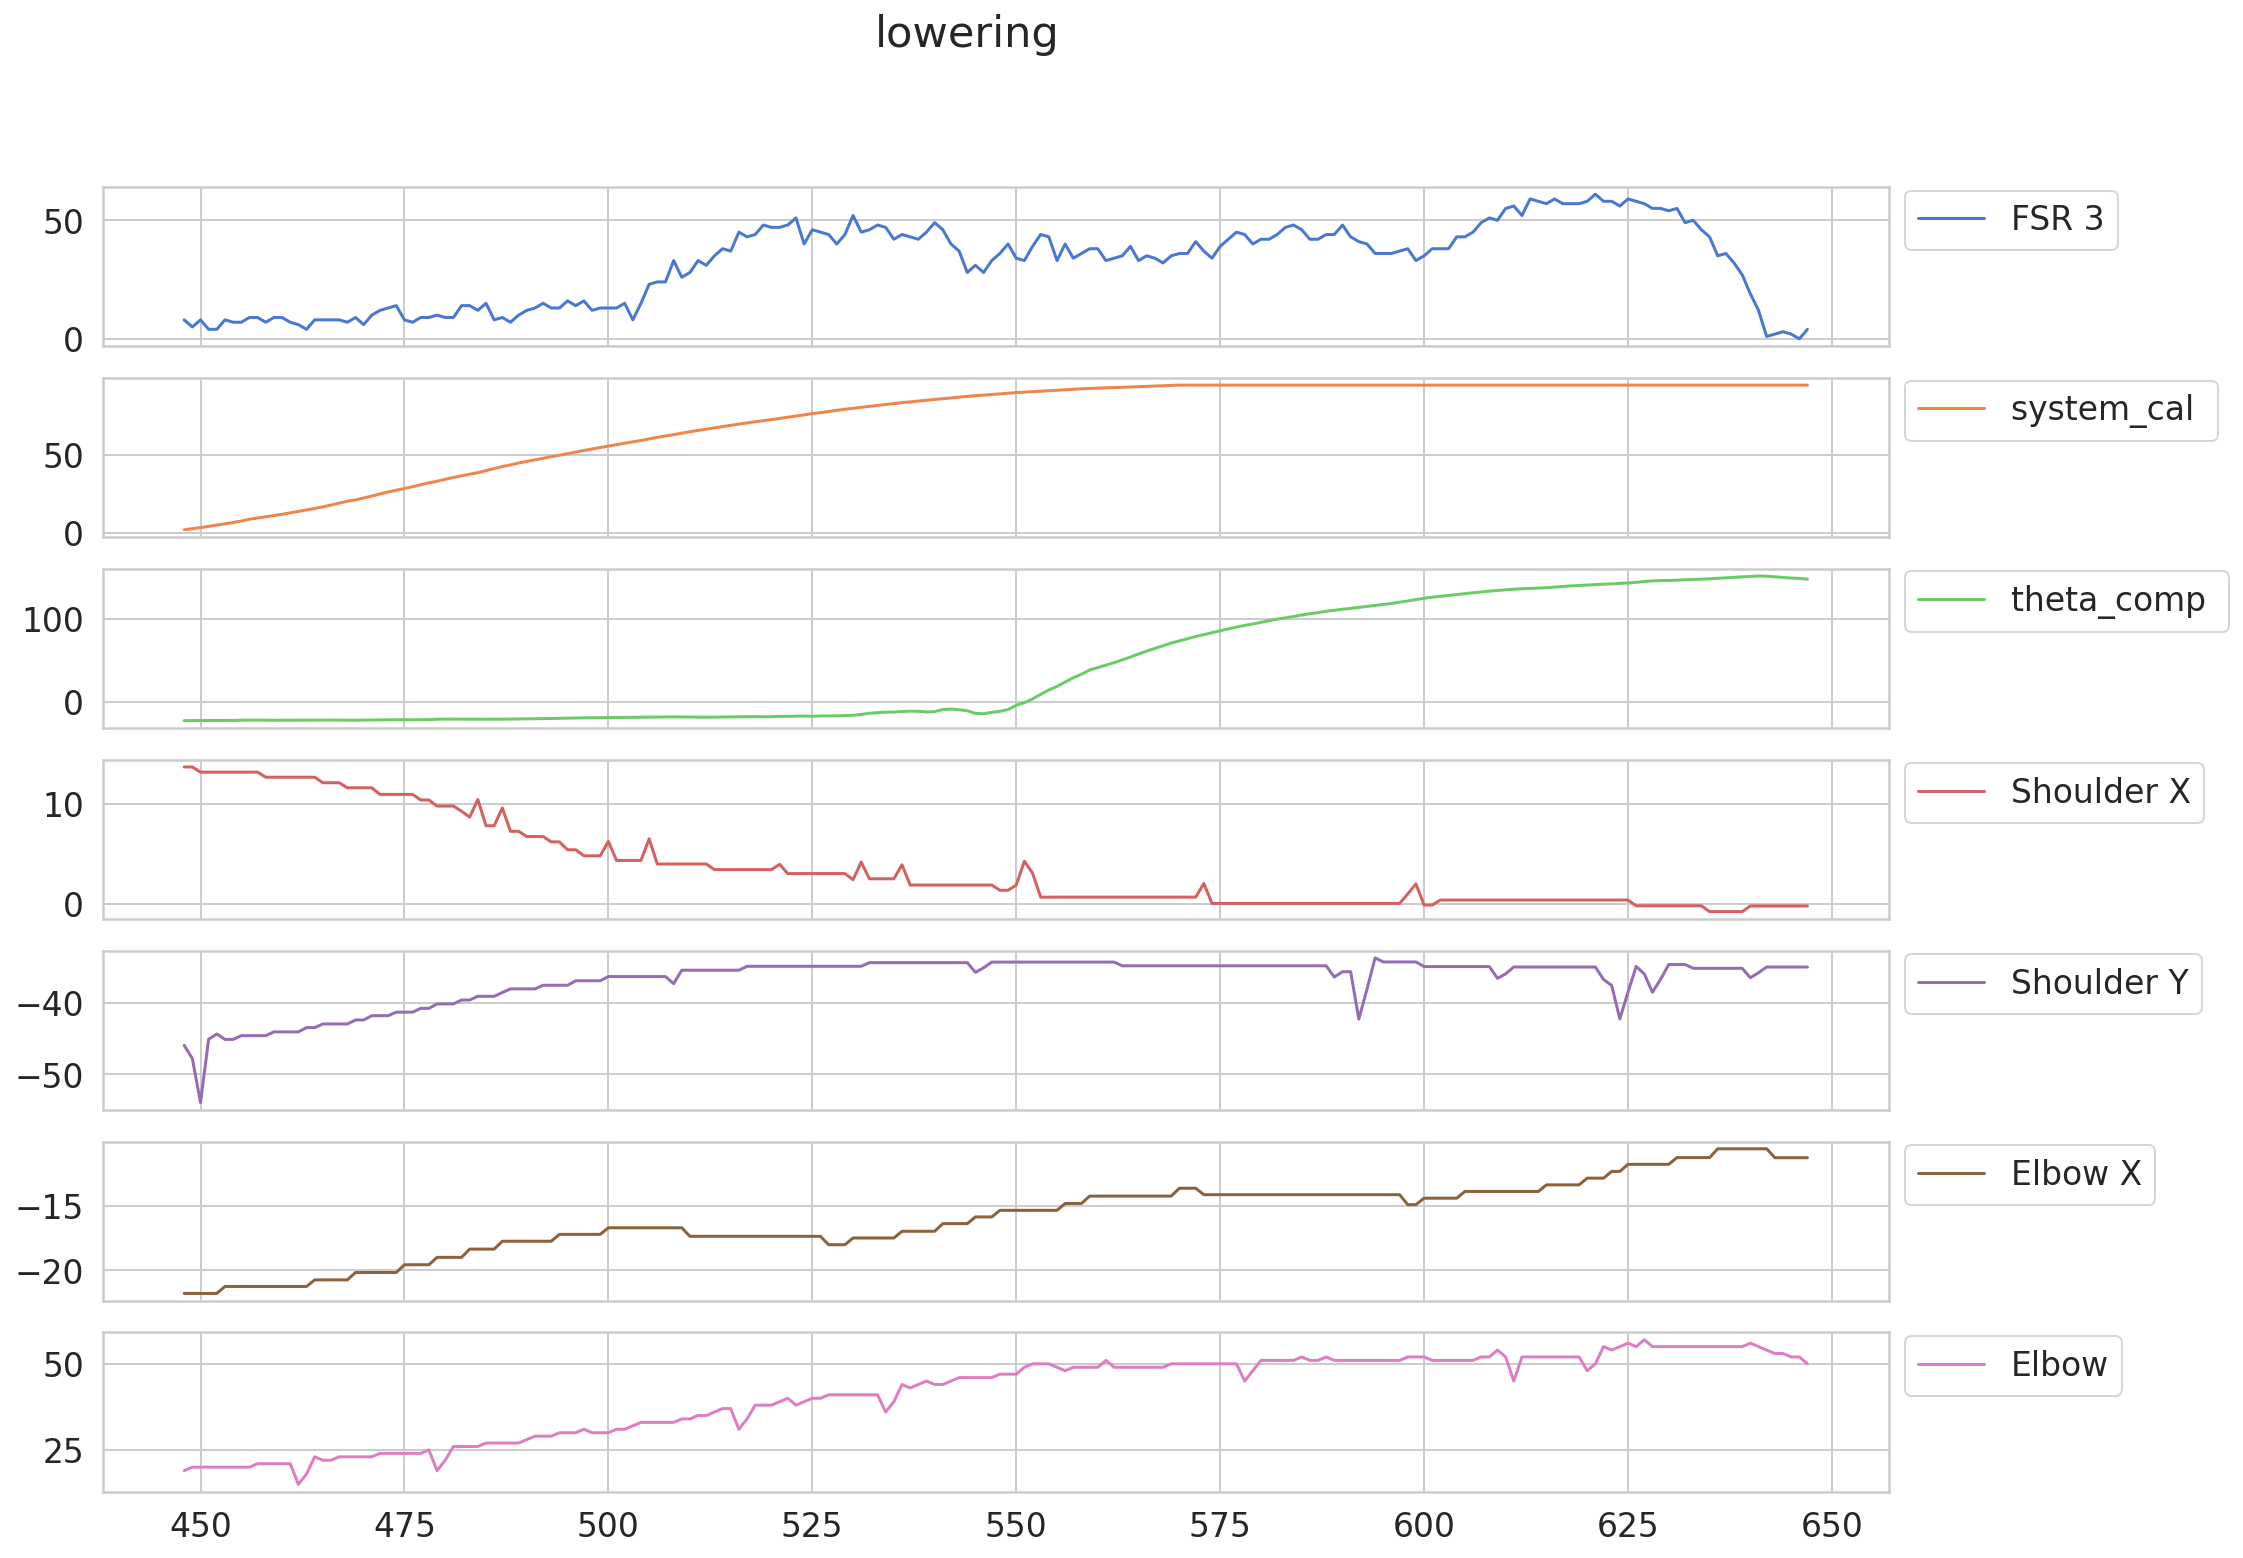

In [15]:
plot_activity("lowering", test)

In [16]:
from sklearn.preprocessing import RobustScaler

df_train = train 
df_test = test

scale_columns = [ 'FSR 3', 'system_cal ', 'theta_comp ', 'Shoulder X',
       'Shoulder Y', 'Elbow X', 'Elbow']

scaler = RobustScaler()

scaler = scaler.fit(df_train[scale_columns].values)

df_train.loc[:, scale_columns] = scaler.transform(df_train[scale_columns].to_numpy())
df_test.loc[:, scale_columns] = scaler.transform(df_test[scale_columns].to_numpy())


In [17]:
from scipy import stats

def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)        
        ys.append(stats.mode(labels)[0][0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

TIME_STEPS = 200
STEP = 10

X_train, y_train = create_dataset(
    df_train[[ 'FSR 3', 'system_cal ', 'theta_comp ', 'Shoulder X',
       'Shoulder Y', 'Elbow X', 'Elbow']], 
    df_train.Task, 
    TIME_STEPS, 
    STEP
)

X_test, y_test = create_dataset(
    df_test[[ 'FSR 3', 'system_cal ', 'theta_comp ', 'Shoulder X',
       'Shoulder Y', 'Elbow X', 'Elbow']], 
    df_test.Task, 
    TIME_STEPS, 
    STEP
)

In [18]:
y_train

array([['lifting'],
       ['lifting'],
       ['lifting'],
       ['lifting'],
       ['lifting'],
       ['lifting'],
       ['lifting'],
       ['lifting'],
       ['lifting'],
       ['lifting'],
       ['lifting'],
       ['holding'],
       ['holding'],
       ['holding'],
       ['holding'],
       ['holding'],
       ['holding'],
       ['holding'],
       ['holding'],
       ['holding'],
       ['holding'],
       ['holding'],
       ['holding'],
       ['holding'],
       ['holding'],
       ['holding'],
       ['holding'],
       ['holding'],
       ['holding'],
       ['holding'],
       ['holding'],
       ['holding'],
       ['holding'],
       ['holding'],
       ['holding'],
       ['holding'],
       ['holding'],
       ['holding'],
       ['holding'],
       ['holding'],
       ['holding'],
       ['lowering'],
       ['lowering'],
       ['lowering'],
       ['lowering'],
       ['lowering'],
       ['lowering']], dtype='<U8')

In [19]:

from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)

enc = enc.fit(y_train)

y_train = enc.transform(y_train)
y_test = enc.transform(y_test)


# from sklearn import preprocessing

# enc = preprocessing.LabelEncoder()
# enc = enc.fit(y_train)
# y_train = enc.transform(y_train)
# y_test = enc.transform(y_test)

In [20]:
print(X_train.shape, y_train.shape)


(47, 200, 7) (47, 3)


In [21]:

from tensorflow.keras.optimizers import SGD

model = keras.Sequential()
model.add(
    keras.layers.Bidirectional(
      keras.layers.LSTM(
          units=256, 
          input_shape=[X_train.shape[1], X_train.shape[2]]
          
      )
    )
)
model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(units=256, activation='relu'))
model.add(keras.layers.Dense(y_train.shape[1], activation='linear'))

opt = SGD(lr=0.01, momentum=0.9)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy'])


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [22]:
train.shape

(662, 9)

In [23]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=30,
    validation_data=(X_test, y_test),
    shuffle=False
)

Epoch 1/20
2/2 [==============================] - 10s 809ms/step - loss: 0.3356 - accuracy: 0.1489 - val_loss: 0.2788 - val_accuracy: 0.6545
Epoch 2/20
2/2 [==============================] - 0s 90ms/step - loss: 0.2915 - accuracy: 0.4681 - val_loss: 0.2399 - val_accuracy: 0.7636
Epoch 3/20
2/2 [==============================] - 0s 83ms/step - loss: 0.2421 - accuracy: 0.7660 - val_loss: 0.2014 - val_accuracy: 0.8182
Epoch 4/20
2/2 [==============================] - 0s 69ms/step - loss: 0.1888 - accuracy: 0.9574 - val_loss: 0.1733 - val_accuracy: 0.8182
Epoch 5/20
2/2 [==============================] - 0s 67ms/step - loss: 0.1692 - accuracy: 0.8723 - val_loss: 0.1553 - val_accuracy: 0.8364
Epoch 6/20
2/2 [==============================] - 0s 58ms/step - loss: 0.1401 - accuracy: 0.9149 - val_loss: 0.1425 - val_accuracy: 0.8545
Epoch 7/20
2/2 [==============================] - 0s 61ms/step - loss: 0.1168 - accuracy: 0.9574 - val_loss: 0.1308 - val_accuracy: 0.8545
Epoch 8/20
2/2 [=========

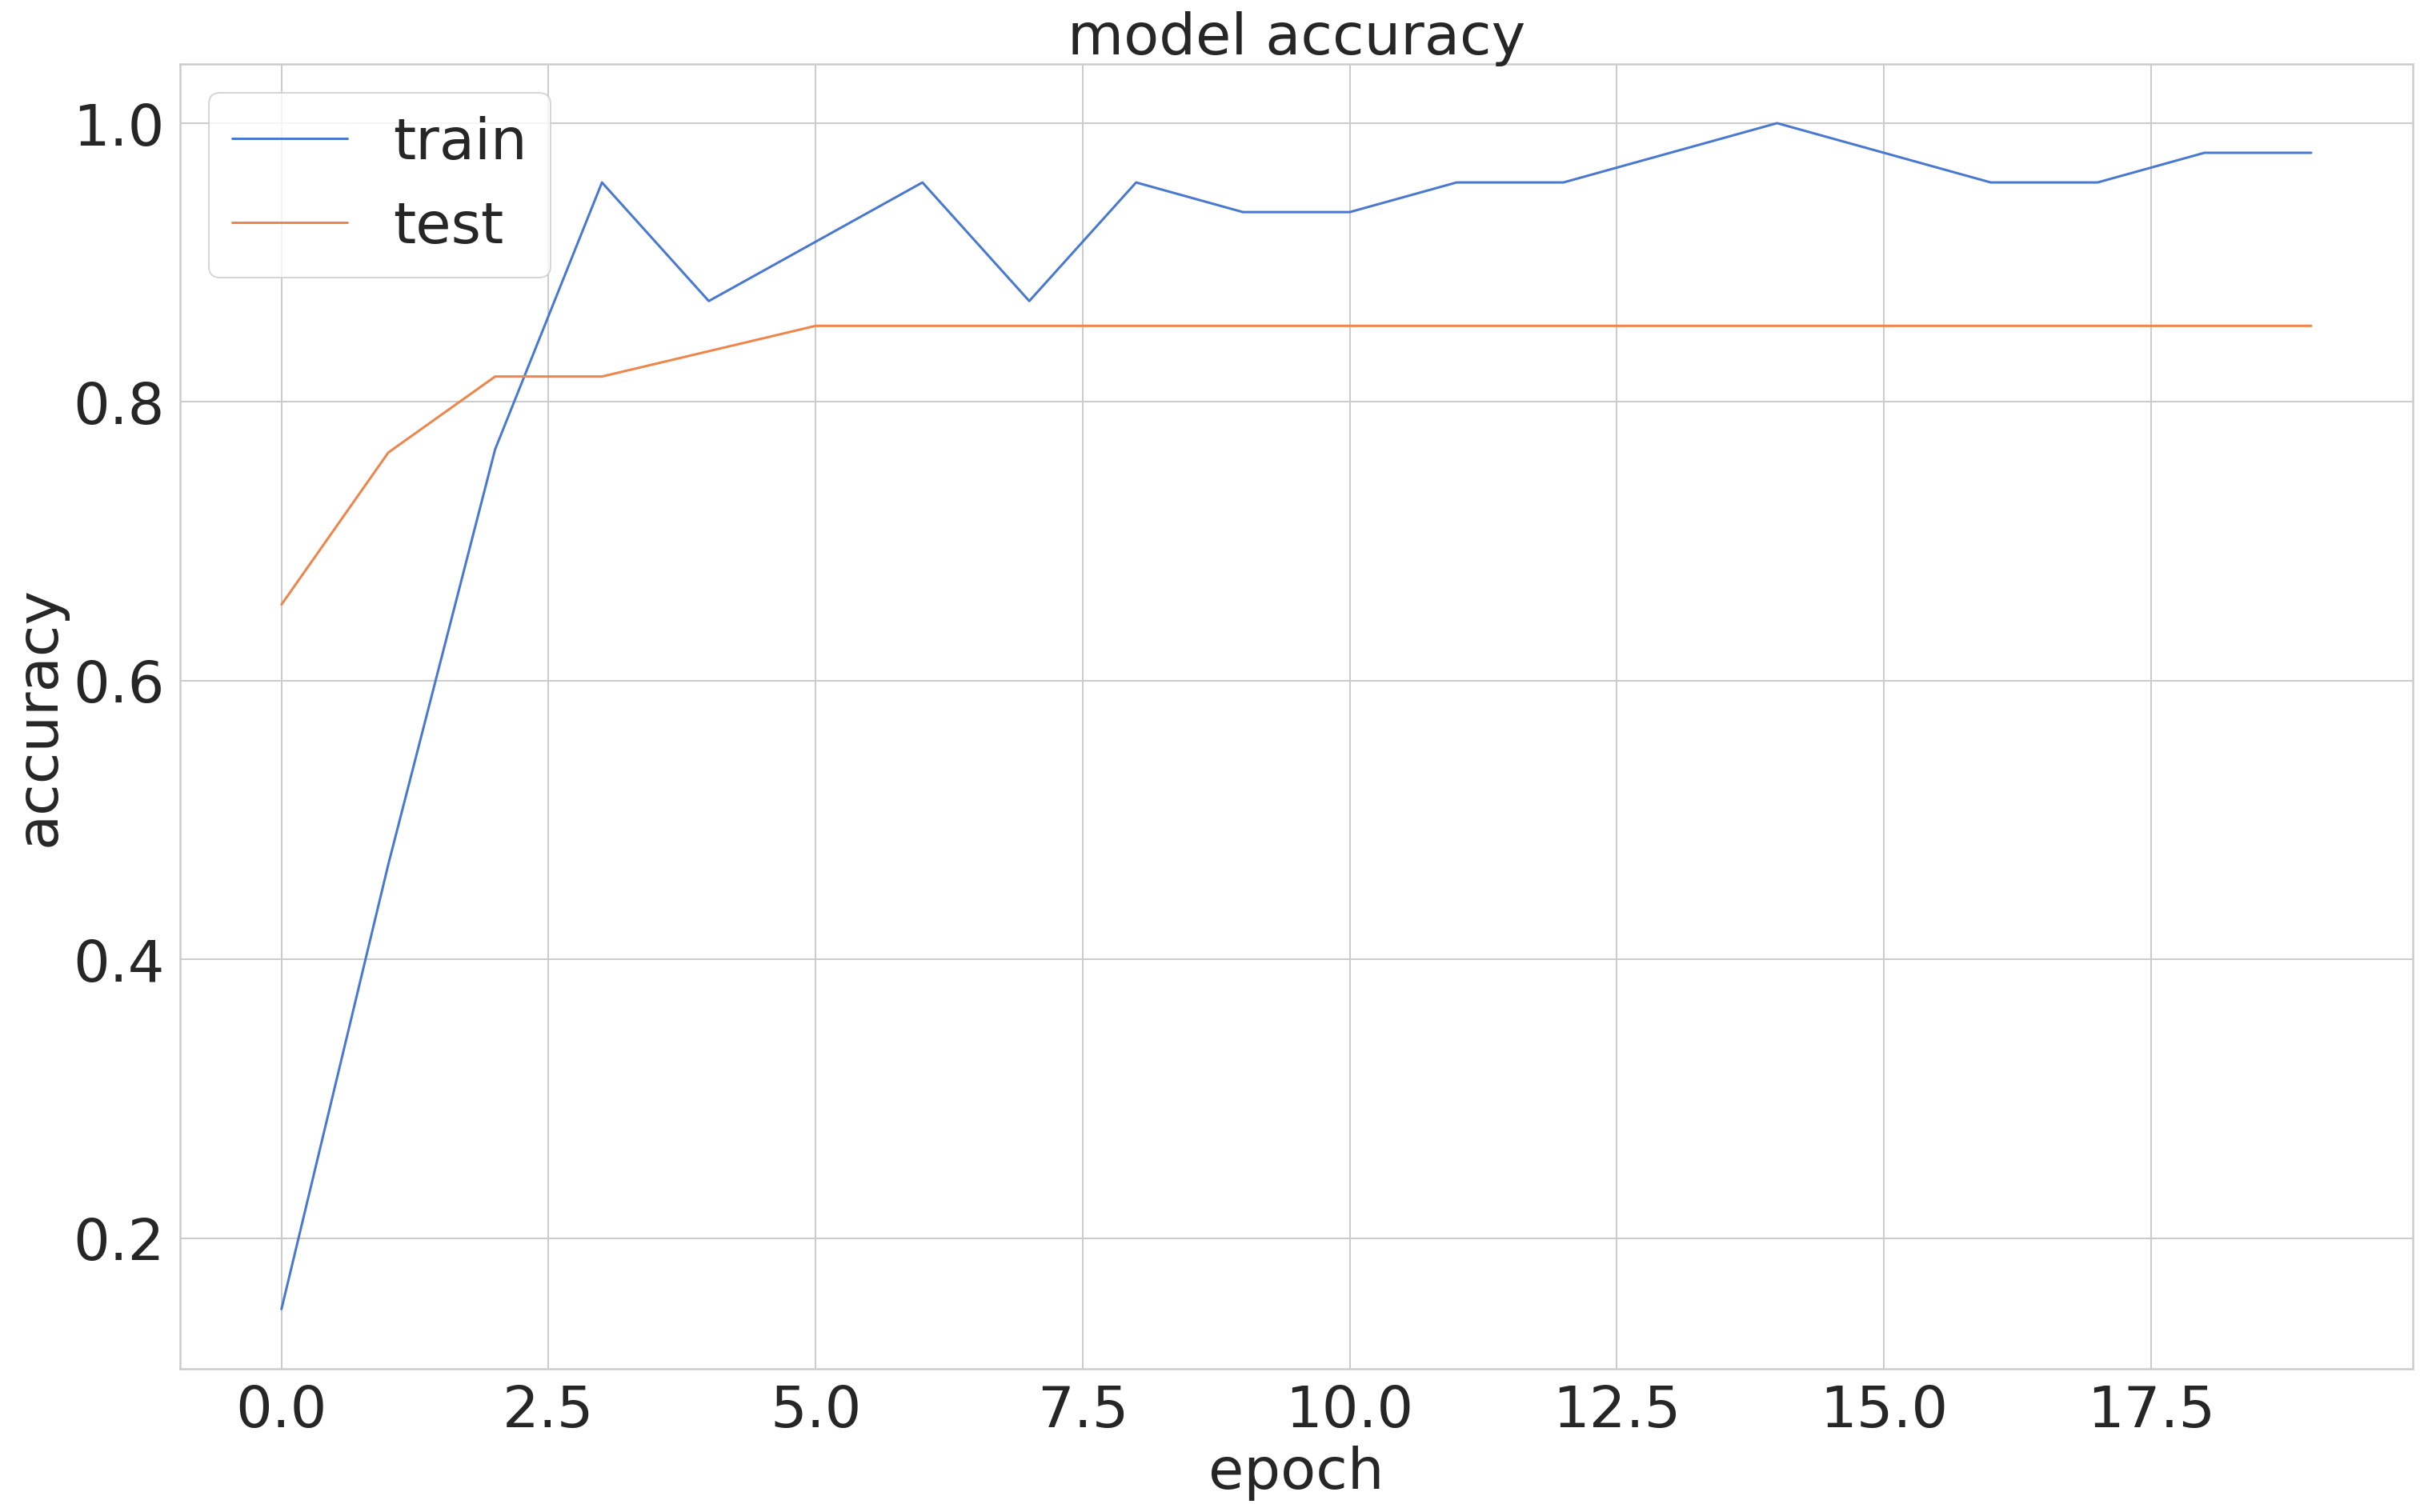

In [41]:
# import matplotlib 
# import matplotlib.pyplot as plt
# from matplotlib import rc

# font = {'family' : 'normal',
#         'weight' : 'normal',
#         'size'   : 22}

# matplotlib.rc('font', **font)

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'large',
          'figure.figsize': (25, 15),
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(params)



plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# # summarize history for loss
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

In [44]:

model.evaluate(X_test, y_test)

2/2 [==============================] - 0s 21ms/step - loss: 0.0882 - accuracy: 0.8545


[0.08823620527982712, 0.8545454740524292]

In [45]:
y_pred = model.predict(X_test)

In [46]:
from sklearn.metrics import confusion_matrix

def plot_cm(y_true, y_pred, class_names):
  cm = confusion_matrix(y_true, y_pred)
  fig, ax = plt.subplots(figsize=(18, 16)) 
  ax = sns.heatmap(
      cm, 
      annot=True, 
      fmt="d", 
      cmap=sns.diverging_palette(220, 20, n=7),
      ax=ax
  )

  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  ax.set_xticklabels(class_names)
  ax.set_yticklabels(class_names)
  b, t = plt.ylim() # discover the values for bottom and top
  b += 0.5 # Add 0.5 to the bottom
  t -= 0.5 # Subtract 0.5 from the top
  plt.ylim(b, t) # update the ylim(bottom, top) values
  plt.show() # ta-da!

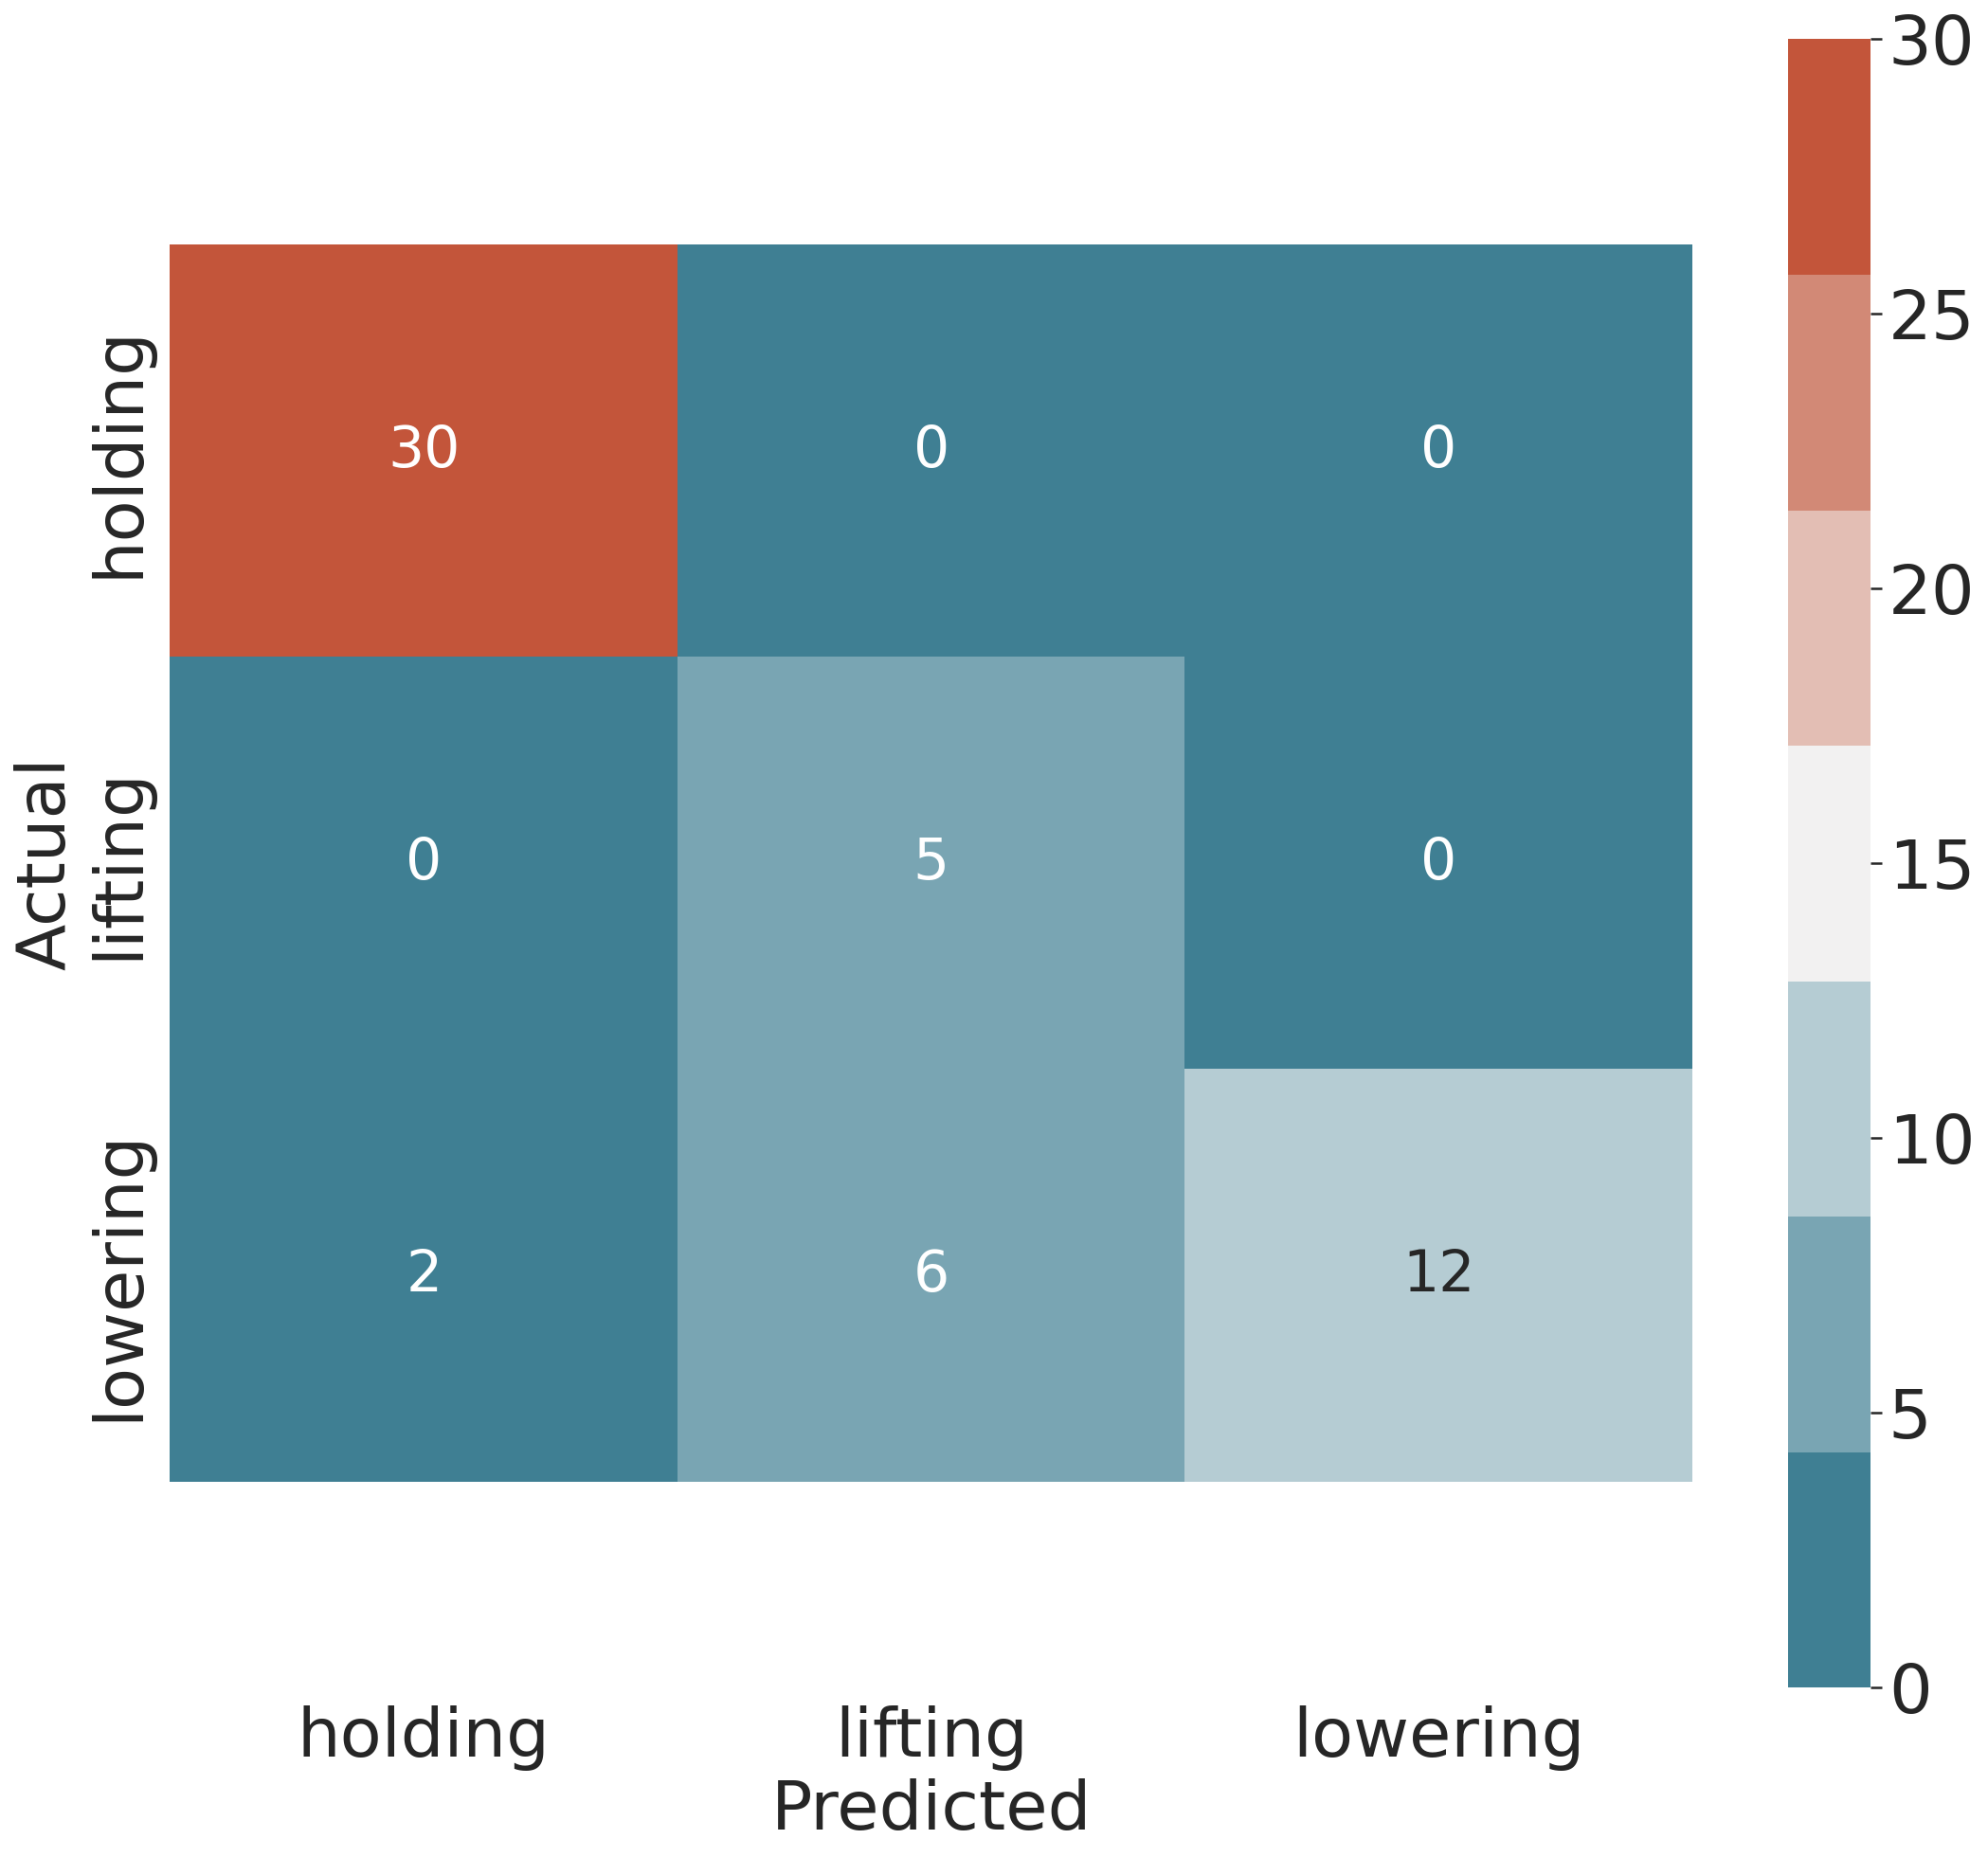

In [47]:
plot_cm(
  enc.inverse_transform(y_test),
  enc.inverse_transform(y_pred),
  enc.categories_[0]
)

In [ ]:
predictions = (model.predict(X_test) > 0.5).astype(int)
# summarize the first 5 cases
for i in range(10):
	#print((X_test[i].tolist()),
  print("///////////////////"),
  print("predicted: "),
  print(predictions[i]),
  print("--------------------"),
  print("expected: "),
  print(y_test[i])
  print("//////////////////")